In [1]:
import scipy.constants

from utilities.IQReceiver.IQReceiver import IQReceiver
from utilities.IQSender.IQSender import IQSender
from utilities.Signals import Signals
from utilities.baseband_pulses.RaisedCosinePulse import RaisedCosinePulse
from utilities.baseband_pulses.RectPulse import RectPulse
from utilities.enums.ModulationCodingScheme import ModulationCodingScheme
from utilities.enums.ModulationCodingSchemeShift import ModulationCodingSchemeShift
from utilities.enums.SynchronizationSequences import SynchronizationSequence
from utilities.plots.iq_sampling_plots import plot_frame, plot_sampling_parameter, plot_iq_samples, plot_shaped_signals, \
    plot_carrier_signals, plot_passband_signals, plot_passband_spectrum, plot_downmixed_signals, plot_lowpass_filter, \
    plot_filtered_spectra, plot_filtered_signals, plot_signals, plot_spectra, plot_iq_symbols
from utilities.enums.BasebandPulseForm import BasebandPulseForm
from utilities.types.Params import Parameters, BasebandParams, FrameParams
import numpy as np
from matplotlib import pyplot as plt
from typing import Union, Sequence

from utilities.synchronization.SynchronizationSequences import SynchronizationSequences

# Am Anfang wird immer in Bursts übertragen, ohne Kontinuierliches Senden

# IQ Sampling

Ziel dieses Notebooks ist es, ein Verständnis für die generierung und Abtastung von IQ-Samples zu entwickeln. Dabei soll Rauschen und der Einfluss des Kanals zunächst vernachlässigt werden. Der Fokus soll hier allein auf dem Verständnis liegen, wie IQ Samples von einem SDR versendet werden, als reales Signal übertragen werden und wie sie empfangen werden.

Am Ende des Notebooks sollte folgendes klar sein:

- Was sind IQ-Samples?
- Das Sendesignal wird immer komplex beschrieben. Übertragen wird jedoch nur der Realteil. Warum?
- Wie werden aus dem realen, analogen Empfangssignal die komplexen IQ-Samples gewonnen?
- Warum können der I- und Q-Teil überlagert ausgesendet werden und dennoch beim Empfänger getrennt werden?

# Theoretischer Background: TX und RX

## Transmitter

Der Transmitter (TX) erzeugt ein diskretes komplexes Basisband-Signal $s_{\text{NF}}[n]$, welches in der Regel als I/Q-Signal bezeichnet wird. Das I/Q-Signal besteht aus zwei Komponenten: der In-Phase-Komponente (I) und der Quadratur-Komponente (Q). Das I/Q-Signal $s_{\text{NF}}[n]$ wird dann auf eine Trägerfrequenz $f_{\text{c}}$ hochgemischt und als analoges Passband Signal $s_{\text{HF}}(t)$ übertragen.



$$s_{\text{NF}}[n] = I[n] + j \text{ } Q[n]$$

* $I[n]$ ist die In-Phase-Komponente (Kosinus Anteil, Realteil)
* $Q[n]$ ist die Quadratur-Komponente (Sinus Anteil, Imaginärteil)
* Bsp.: QPSK-Sample
$$
\begin{align*}
s_{\text{QPSK}} &= 1 + j \\
                &= \sqrt{2} \text{ } e^{j\frac{\pi}{4}} \\
                &=  \sqrt{2} \cos(\frac{\pi}{4}) + j \sqrt{2}  \sin(\frac{\pi}{4}) \\
                &= I + j Q
                &= \sqrt{2} \left(\frac{\sqrt{2}}{2} + j \frac{\sqrt{2}}{2}\right) \\
                &= 1 + j
\end{align*}
$$

![IQ Sampling Receiver](./images/IQ_diagram_sender.png)

Werden die IQ-Samples vom ausgesendet, werden sie als reales Signal übertragen.

### Im SDR wird das wie im Blockschaltbild folgendermaßen realisiert:
- Es wird ein $\cos{2 \pi f_c t}$ generiert, mit Trägerfrequenz $f_{\text{c}}$ generiert
- Dieser wird dann zum einen mit der realen Komponente (I-Komponente) multipliziert
- Für die imaginäre Komponente (Q-Komponente) wird auf den Cosinus eine Phasenverschiebung von $\frac{\pi}{2}$ angewendet: $\cos{(2 \pi f_c t + \frac{\pi}{2})} = - \sin(2 \pi f_c t)$
- Dieser wird dann zum einen mit der realen Komponente (Q-Komponente) multipliziert
- Durch das Superpositionsprinzip addieren sich beide Komponenten zu:
$$
    s_{\text{HF}}(t) = I(t) \cos(2 \pi f_{\text{c}} t) - Q(t) \sin(2 \pi f_{\text{c}} t)
$$

#### Bemerkung Orthogonalität:
Die beiden Signale sind orthogonal zueinander, d.h. das Skalarprodukt ist 0. Das bedeutet, dass die beiden Signale unabhängig voneinander sind und der Empfänger die I und Q Komponenten aus der Summe extrahieren kann.

In [2]:
def normalize_energy(signal):
    energy = np.sum(np.abs(signal) ** 2)
    return signal / np.sqrt(energy)

## Generierung des Sendesignals

Das Sendesignal wird aus den Datenbits und einer Synchronisationssequenz generiert. Die Synchronisationssequenz wird verwendet, um den Empfänger zu synchronisieren. Das Sendesignal wird dann mit einem Raised-Cosine Filter gepulst, um die Bandbreite des Signals zu begrenzen.

### Konvertierung der Datenbits $\vec{b}[m]$ in BPSK Samples

   $$
    \text{BPSK}(i) = \vec{b}[i] \cdot 2 - 1
   $$

Es sollen T = 8 Samples pro Symbol verwendet werden. Das Sendesignal wird dann wie folgt generiert:

$$
    x_{\text{NF, no shape}}[n] = \sum_{i=0}^{N-1} \text{BPSK}(i) \delta\left(n - i T\right)
$$

Für IQ-Modulation wird das für den I und Q Teil getrennt durchgeführt, somit ergibt sich:

$$
    x_{\text{I, no shape}}[n] = \Re\left\{x_{\text{NF, no shape}}[n]\right\}
$$
$$
    x_{\text{Q, no shape}}[n] = \Im\left\{x_{\text{NF, no shape}}[n]\right\}
$$

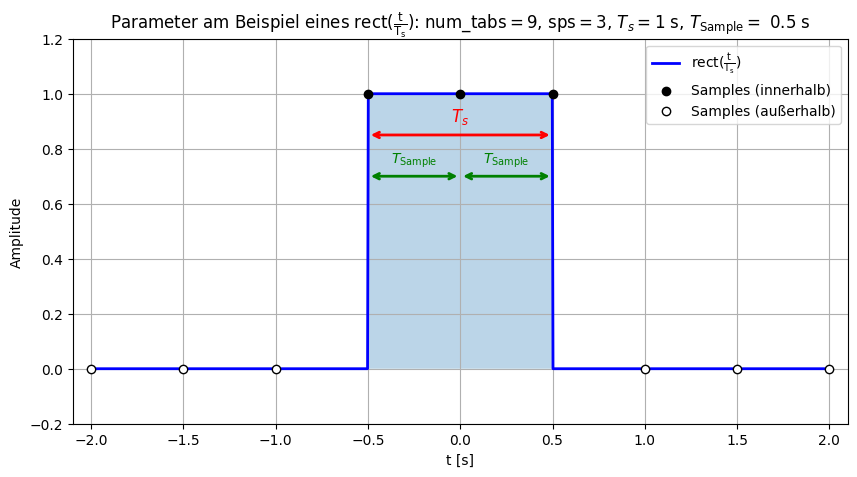

In [3]:
plot_sampling_parameter()

#### Aufgabe 1:
- Machen Sie sich mit den nachfolgenden Parametern vertraut, diese werden nachfolgend immer wieder verwendet und spielen eine wichtige Rolle für die korrekte Auflösung der Signale
- Befolgen Sie die Anweisungen in den Kommentaren (Sie können die Parameter auch selbst sinnvoll frei wählen).

In [4]:
params = Parameters(
    baseband=BasebandParams(
        T_s=1/2,
        sps=8,
        num_samps=101,
        pulseform=BasebandPulseForm.RAISED_COSINE,
        amplitude=1,
        roll_off=0.35
    ),
    frame=FrameParams(
        num_sync_syms=16,
        num_data_syms=128,
        mcs=ModulationCodingScheme.BPSK,
        sync_sec=SynchronizationSequence.ZADOFF_CHU,
        pilot_start_idx=0,
        pilot_repetition=5,
        pilot_zc_root=25
    )
)
# Nun noch die Dauer eines Samples

print(f"Die Sample Dauer T_s ergibt sich durch T_sample = T_s / sps = {params.baseband.T_sample}")

Die Sample Dauer T_s ergibt sich durch T_sample = T_s / sps = 0.0625


## Generierung der Bits $\vec{b}[m]$

#### Aufgabe 2:
- Erstellen Sie ein beliebige Datenbits in `data_bits`
- `data_bits`: $\vec{b}[m] \in \{0,1\}$

In [5]:
data_bits = np.array([0,0,1,1,1,0,0,1,1,1,0,0,1,1,1,0,0,1,1,1])

<Figure size 1920x1440 with 0 Axes>

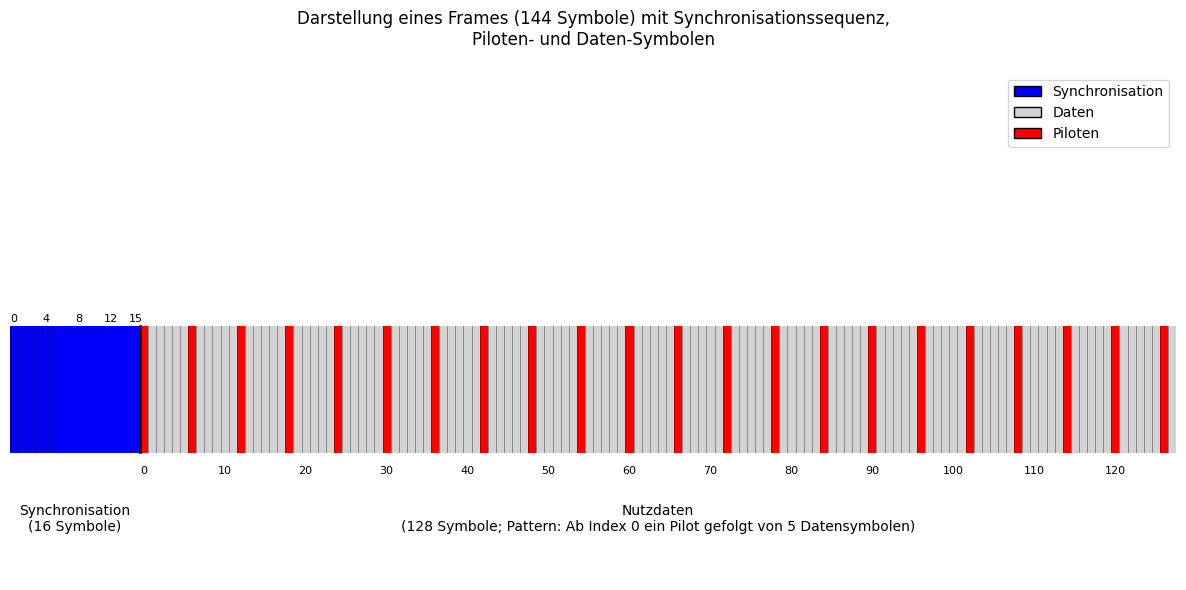

In [6]:
plot_frame(frame_params=params.frame)

In [7]:
iq_sender = IQSender(data_bits, params.frame, params.baseband)

Aufgabe 3.1: BPSK Modulation
Aufgabe 4.1: Befüllung des Frames.
Aufgabe 6: Bilden Sie die Modulationssymbole mit den Synchronisationssymbolen.
Aufgabe: Bilden Sie die Dirac-Impulsfolge mit den Modulationssymbolen.
Aufgabe 8: Formen Sie die Symbole mit dem Basisbandpuls.


### Mapping der Bits $\vec{b}[m]$ auf Modulationssymbole & Erstellung eines Frames

- Ziel: NumPy Array mit den Modulationssymbolen
- $\vec{b}[m]$ wird auf ein Modulationssymbole $d(l)$ gemappt
- Anweisung: Überlegen Sie sich, wie Sie die Bits auf die Modulationssymbole mappen. Verwenden Sie ein Gray-Mapping.

#### Aufgabe 3.1: BPSK
- Implementieren sie die Funktion `bpsk_modulation(data_bits)` in sdr-module/utilities/IQSender/Modulator.py

#### Aufgabe 3.2: QPSK
- Implementieren sie die Funktion `qpsk_modulation(data_bits)` in sdr-module/utilities/IQSender/Modulator.py

### Hinweis: Durch nachfolgenden Aufruf wird eine der beiden Funktionen automatisch aufgerufen (Je nachdem, welches MCS in den `params` konfiguriert wurde).

In [8]:
modulation_data_symbols = iq_sender.modulate()

Aufgabe 3.1: BPSK Modulation


#### Aufgabe 4: Befüllung des obigen Frames, basierend auf den `params`

- Es soll in obigem Plot der graue Teil mit den Modulationssymbolen befüllt werden
- Auf graue Blöcke kommt ein Modulationssymbol
- Auf rote Blöcke kommt ein Symbol der Pilotensequenz
- Die Pilotensequenz erhalten Sie in der Klasse IQSender (utilities/IQSender/IQSender.py) mit `self.create_pilot_seq()`

##### 4.1:
- Implementieren Sie die Methode `fill_frame()` in utilities/IQSender/IQSender.py
- Der Output sollte ein Array des rechten Teils des obigen Frames sein (die Sychronisationssequenz folgt später)
- Die Indizes für Piloten füllen Sie bis zum letzten möglichen Index auf
- Die Indizes für Nutzdaten füllen sie mit den Modulationssymbolen solange, bis sie keine mehr haben
- Hat der Frame danach freie Plätze, so können diese Indexe als `zero_padded_indexes` betrachtet werden und mit Nullen aufgefüllt werden
- Hinweis: Sie müssen aus den `self.params` (die haben sie oben selbst definiert) die notwendige Länge der Pilotensequenz bestimmen und damit `self.create_pilot_seq()` aufrufen
- Erwarteter Output:
    - Tupel (frame_samples_data_pilots, zero_padded_indexes)
        - Numpy Array: `frame_samples_data_pilots`
        - Numpy Array: `zero_padded_indexes`

In [9]:
# add pilots via multiplexing
modulation_data_symbols_with_pilots, zero_padded_indexes = iq_sender.fill_frame()
print(modulation_data_symbols_with_pilots.size)

Aufgabe 4.1: Befüllung des Frames.
128


#### Besonderheit der Pilotensequenz:

- Sie trägt die Information des von Ihnen konfigurierten MCS `params.frame.mcs`
- Die Pilotensequenz ist eine ZC-Sequenz und trägt die Wurzel `params.frame.pilot_zc_root`
- Bei der Generierung in `IQSender.create_sync_seq` wurde Sie zyklisch um einen `mcs_shift` verschoben
- Das Mapping zwischen MCS und `mcs_shift` findet sich in utilities/enums/ModulationCodingSchemeShift.py

<Figure size 1920x1440 with 0 Axes>

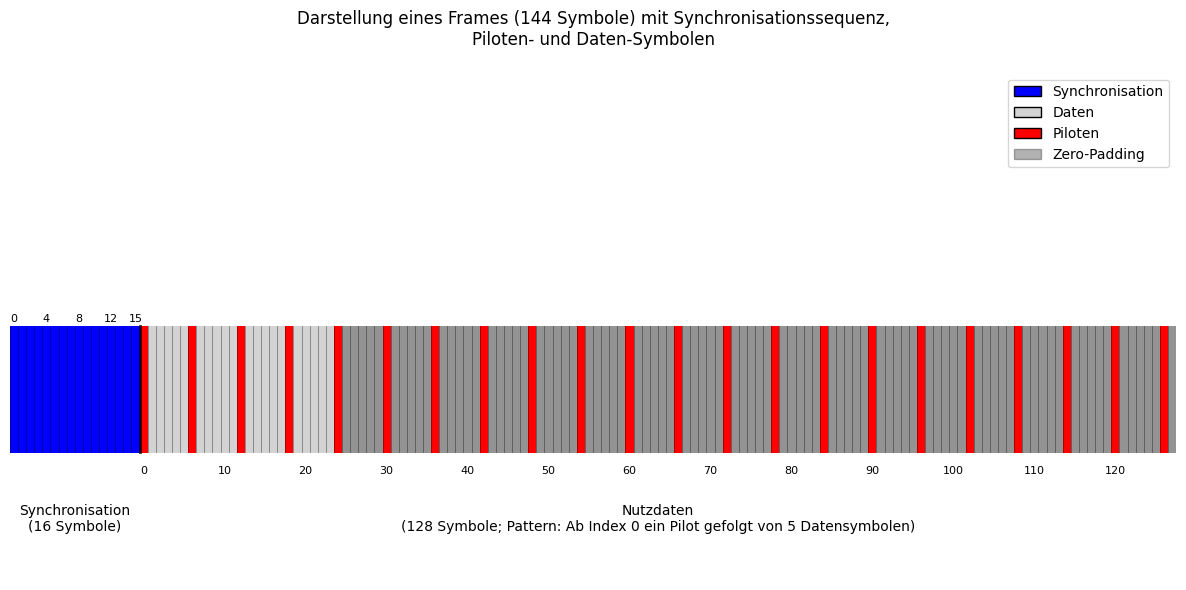

In [10]:
plot_frame(frame_params=params.frame, zero_padded_indexes=zero_padded_indexes)

## Generation der Synchronisationssequenz

Hier soll es um den blauen Teil des Frames gehen.

- Die Funktion utilities/IQSender/IQSender.create_sync_seq() ist bereits vollständig für eine M-Sequenz und eine ZC-Sequenz implementiert
- In dieser Aufgabe ist es das Ziel, eine Barker Sequenz zur Synchronisation zu erweitern

#### Aufgabe 5:
- Erweitern Sie das ENUM utilities/enums/SynchronizationSequences.py
- Erweitern Sie die Generation einer Barker-Sequenz in utilities/synchronization/SynchronizationSequences.py
- Erwarteter Output: utilities/IQSender/IQSender.create_sync_seq() funktioniert auch, wenn oben in den `params.frame.sync_seq` ihre neu hinzugefügte Barker-Sequenz angegeben wird

Scheint das zu komplex, könnten Sie auch einfach eine der bereits existierenden verwenden.

In [11]:
synchronization_sequence = iq_sender.create_sync_seq()

#### Aufgabe 6:
- Ziel: Symbole der Synchronisationssequenz & Datensymbole in einem Array von Modulationssymbolen $d(l)$
- Implementieren Sie die Funktion utilities/IQSender/IQSender.concatenate_sync_and_data_symbols()
- Dabei soll im IQSender die Synchronisationssequenz `self.sync_seq` und der Datenteil mit den Piloten des Frames `self.modulation_symbols_with_pilots` konkateniert werden


In [12]:
symbols = iq_sender.concatenate_sync_and_data_symbols()

Aufgabe 6: Bilden Sie die Modulationssymbole mit den Synchronisationssymbolen.


## Pulse Shaping:

Hierfür werden zwei Dinge benötigt:

1. Design Basisbandimpulse $h_{\text{Pulse Form}}[n]$
2. Dirac-Summe mit Modulationssymbolen $x_{\text{no shape}}[n]$

Die Basisbandimpulse sind bereits implementiert, um ihnen die Arbeit zu erleichtern. Sie können diese einfach verwenden. Nachfolgende Codezelle plottet den von ihnen in den `params.baseband` konfigurierten Basisbandimpuls.

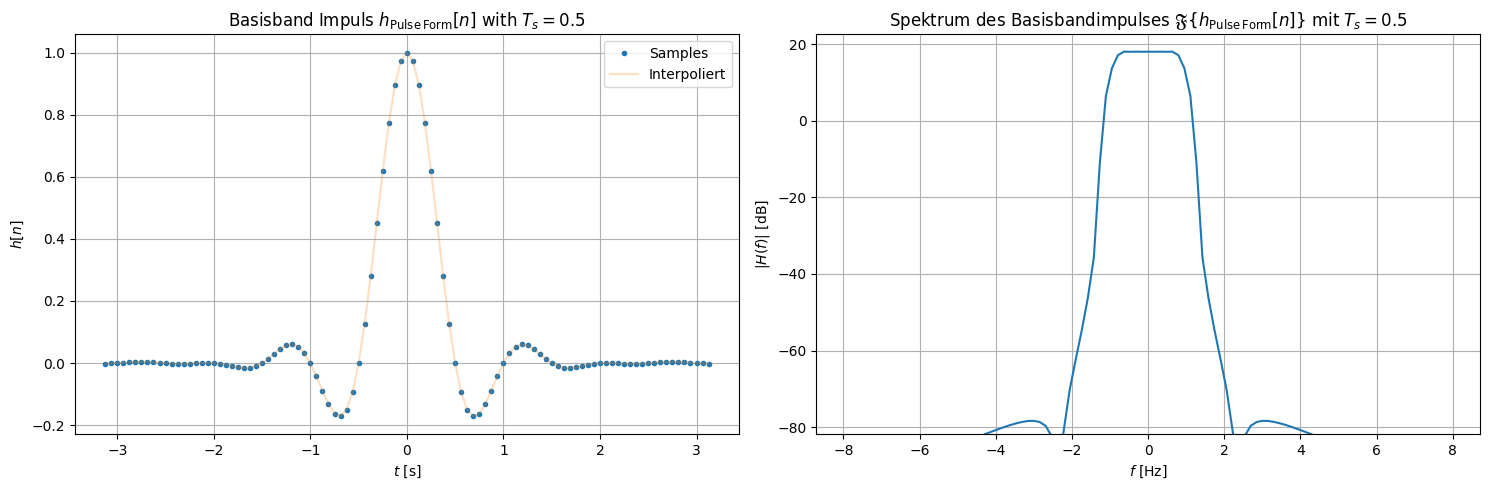

In [13]:
if params.baseband.pulseform is BasebandPulseForm.RECT:
    h_pulse_form = RectPulse.from_baseband_params(baseband_params=params.baseband)
elif params.baseband.pulseform is BasebandPulseForm.RAISED_COSINE:
    h_pulse_form = RaisedCosinePulse.from_baseband_params(baseband_params=params.baseband)

h_pulse_form.plot()

### 2. Dirac-Summe der Modulationssymbole `symbols` $x_{\text{no shape}}[n] = \sum_{l=0}^{L-1} d(l) \text{ } \delta\left(t - l T_s\right) $

- Ziel: NumPy Array mit der Dirac-Summe $x_{\text{no shape}}[n]$.
- Die Modulationssymbole des gesamten Frames liegen zwei Codezellen oberhalb in `symbols`

Es wird benötigt:

1. Eine Dirac-Summe $x_{\text{I,no shape}}[n]$ für den I-Anteil, welche die Realteile der Symbole $ \Re \{d(l) \} $ enthält
2. Eine Dirac-Summe $x_{\text{I,no shape}}[n]$ für den Q-Anteil, welche die Imaginärteile der Symbole $ \Im \{d(l) \} $ enthält
- Hinweis: Die Zeit $t$ ist diskret, wobei ein Indexbin $n$ einem Zeitpunkt $t = n \cdot T_{\text{Sample}}$ entspricht
    - Die Dauer eines Samples $T_{\text{sample}}$ ist gegeben durch: $T_{\text{sample}} = \frac{T_s}{\text{sps}}$
- Das bedeutet die einzelnen Dirac-Summanden brauchen einen zeitlichen Abstand von $T_{\text{s}}$,
was in Samples durch die Beziehung $T_{Sample} $  [ $ \frac{s}{Sample} $] $ =  \frac{T_s}{sps} \text{ } $[ $ \frac{s}{Sample} $] gegeben ist. Durch Umstellen ergibt sich der Abstand in Samples durch:

$$ \text{sps} = \frac{T_s}{T_{\text{Sample}}} \quad \text{, die Einheit beider Seiten ist nun Samples}$$

In Bins ausgedrückt ergeben sich die Dirac-Summen $x_{\text{I,no shape}}[n]$ & $x_{\text{Q,no shape}}[n]$ zu:

$$
    x_{\text{I, no shape}}[n] = \sum_{l=0}^{L-1} \Re \{d(l) \} \text{ } \delta\left(n - l \text{ sps}\right) \quad \text{, mit } L = \text{len(d(l) )}\cdot sps
$$
$$
    x_{\text{Q, no shape}}[n] = \sum_{i=0}^{N-1} \Im \{d(l) \}  \text{ } \delta\left(n - l \text{ sps}\right) \quad \text{, mit } N = \text{len(d(l) )}\cdot sps
$$

#### Aufgabe 7: Implementierung von IQSender.dirac_sum_with_frame_symbols().
- Erstellen Sie die Dirac-Summe $x_{\text{I, no shape}}[n]$ in `x_no_shaped`
- Erstellen Sie die Dirac-Summe $x_{\text{Q, no shape}}[n]$ in `x_no_shaped`
- Erstellen Sie zusätzlich die Zeitvariable `t`, beachten Sie dass zwischen jedem Sample in `t` der Abstand `T_Sample` sein muss. (Im IQSender liegt die Information in `self.baseband_params.T_sample`)
- Hinweis: Sie können für $\delta (t - \tau)$ `Signals.delta_distribution(t, tau)` verwenden


In [14]:
x_iq_no_shape = iq_sender.dirac_sum_with_frame_symbols()

x_i_no_shape = x_iq_no_shape.I
x_q_no_shape = x_iq_no_shape.Q

Aufgabe: Bilden Sie die Dirac-Impulsfolge mit den Modulationssymbolen.


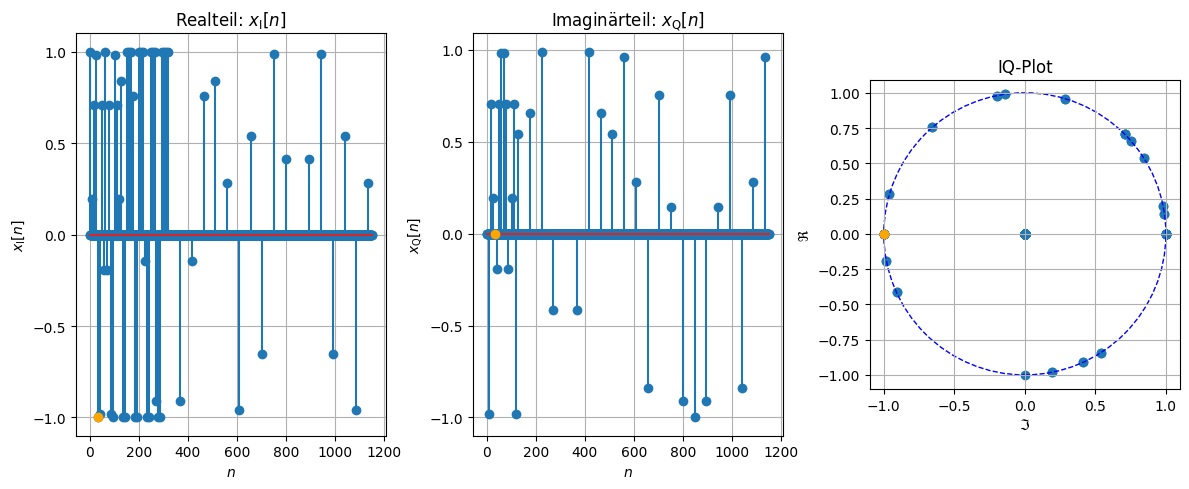

In [15]:
fig, axes = plot_iq_samples(x_i=x_i_no_shape, x_q=x_q_no_shape, sps=params.baseband.sps)
plt.show()

## Pulsformung

Um das Basisbandsignal $x_{\text{I, shaped}}[n] $ & $x_{\text{Q, shaped}}[n]$ müssen die Diracsummen $x_{\text{I, no shape}}[n]$ & $x_{\text{Q, no shape}}[n]$ mit einem Basisband Puls $h_{\tiny{\text{Pulse Form}}}[n]$ geformt werden. Dies wird durch eine Faltung wie folgt erreicht:

$$
    x_{\text{I, shaped}}[n] = x_{\text{I, no shape}}[n] * h_{\tiny{\text{Pulse Form}}}[n]
$$
$$
    x_{\text{Q, shaped}}[n] = x_{\text{Q, no shape}}[n] * h_{\tiny{\text{Pulse Form}}}[n]
$$

#### Aufgabe 8: Pulse Shaping

##### Aufgabe 8.1: Implementierung von IQSender.shape_symbols()
- $ h_{\tiny{\text{Pulse Form}}}[n] $ erhalten Sie innerhalb von shape_symbols() im IQSender via `self.h.generate_pulse()`
- Berechnung von $x_{\text{I, shaped}}[n]$ in `x_iq_shaped.I` (mithilfe von `self.x_iq_no_shape.I` und `h`)
- Berechnung von $x_{\text{Q, shaped}}[n]$ in `x_iq_shaped.Q` (mithilfe von `self.x_iq_no_shape.I` und `h`)
##### Aufgabe 8.2: In nachfolgender Jupyter Zelle erweitern
- Erstellen Sie ein passenden Zeitvektor `t`
- Berechnen Sie $\mathfrak{F} \{x_{\text{I, shaped}}[n] \}$ und speichern Sie das Ergebnis in `x_i_shaped_spectrum`
- Berechnen Sie $\mathfrak{F} \{x_{\text{Q, shaped}}[n] \}$ und speichern Sie das Ergebnis in `x_q_shaped_spectrum`
- Erstellen Sie in der korrekten Auflösung den zugehörigen Frequenzvektor `f`
- Hinweise:
    - Nutzen Sie die Funktion `np.convolve` für die Faltung

In [16]:
x_iq_shaped = iq_sender.shape_symbols()

x_i_shaped = x_iq_shaped.I
x_q_shaped = x_iq_shaped.Q


# TODO: Zuweisungen für aufgabe 8 entfernen nachfolgend
t = np.arange(x_i_shaped.size) * params.baseband.T_sample

x_i_shaped_spectrum = np.fft.fftshift(np.fft.fft(x_i_shaped))
x_q_shaped_spectrum = np.fft.fftshift(np.fft.fft(x_q_shaped))
f = np.fft.fftshift(np.fft.fftfreq(x_i_shaped.size, params.baseband.T_sample))

Aufgabe 8: Formen Sie die Symbole mit dem Basisbandpuls.


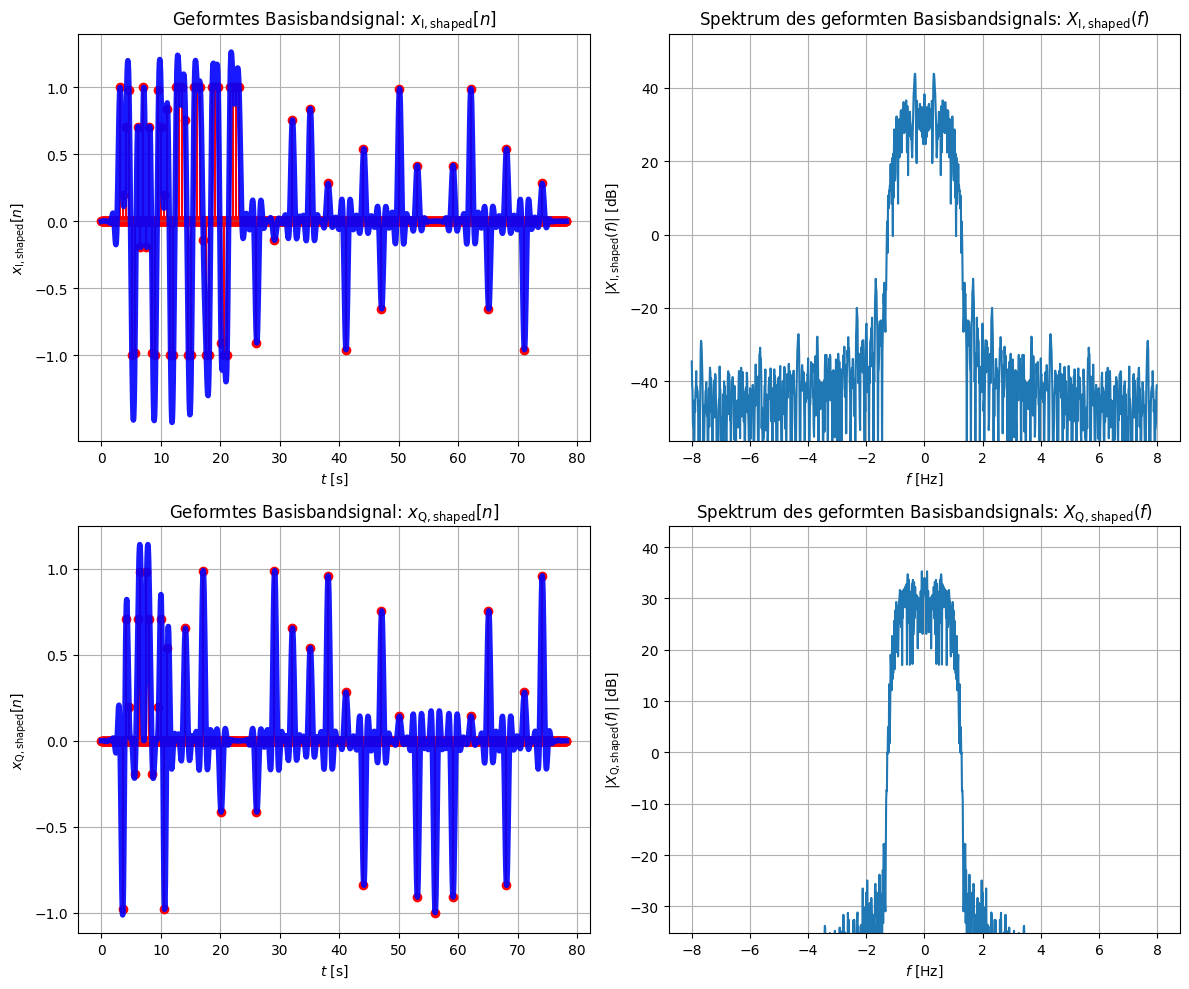

In [17]:
plot_shaped_signals(h_pulse_form, x_i_no_shape, x_i_shaped, x_i_shaped_spectrum, x_q_no_shape, x_q_shaped, x_q_shaped_spectrum, t, f)

## Problem: Übergang ins "analoge Passband"

Die Träger und das Passband sind analog. Alles was im Rahmen der Simulation dieses Notebooks gemacht wurde und gemacht werden kann ist zeitdiskret.

Um also das Hochmischen ins Passband zu simulieren, müssen `x_i_shaped` und `x_q_shaped` mit Trägern multipliziert werden. Damit das technisch umsetzbar ist, müssen die Träger die gleiche Anzahl der Samples haben, wie auch `x_i_shaped` und `x_q_shaped`.

Nun das Problem: Für hohe Trägerfrequenzen $f_c$ reichen die Anzahl der Samples von `x_i_shaped` und `x_q_shaped` nicht aus, um der minimal notwendigen Abtastrate der Träger mit $f_c$ gerecht zu werden.

### Lösung: Oversampling von `x_i_shaped` und `x_q_shaped`

##### Aufgabe 9: Oversampling von `x_i_shaped` und `x_q_shaped`

- Implementieren Sie die nachfolgenden Funktionen `oversample_signal` und `invert_oversampling`
    - Hinweis Oversampling: Für das Oversampling, muss jedes Sample `oversampling_factor`-mal wiederholt werden. Informieren Sie sich, wie sie dies mit der NumPy-Funktion `np.repeat` umsetzen können.
    - Hinweis Umkehrung des Oversamplings: Realisierbar durch Abtastung des Oversampled-Signals mit der Abtastrate $f_s$ = `oversampling_factor`
- Definieren Sie einen Wert für den `oversampling_factor` der zu Ihrer $f_c$ in der übernächsten Zelle passt.
- Oversampling von `x_i_shaped` und `x_i_shaped` in `x_i_oversampled` und `x_q_oversampled`


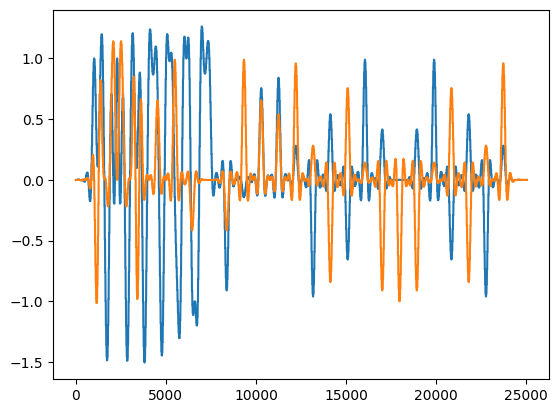

In [18]:
def oversample_signal(signal, oversampling_factor):
    return np.repeat(signal, oversampling_factor)

def invert_oversampling(signal, oversampling_factor):
    return signal[::oversampling_factor]

# Oversample the signals by a factor of 8
oversampling_factor = 20
x_i_oversampled = oversample_signal(x_i_shaped, oversampling_factor)
x_q_oversampled = oversample_signal(x_q_shaped, oversampling_factor)

plt.plot(x_i_oversampled)
plt.plot(x_q_oversampled)

### Aufbau des Trägersignals

![IQ Sampling Receiver](./images/IQ_diagram_sender.png)

- Gemäß des Blockschaltbildes brauchen wir ein Carrier $s_c(t)$, welcher das Basisbandsignal auf eine Trägerfrequenz $f_c$ hochmischen kann
- Dieser wird direkt mit dem I-Anteil des Basisbandsignals $x_{\text{I, shaped}}(t)$ multipliziert
- Der I-Anteil wird laut obigen Berechnungen mit dem Cosinus übertragen. Blockschaltbild konform muss $s_c(t)$ für den I-Anteil also wie folgt aussehen:
$$
    s_{\text{c,I}}(t) = \cos(2 \pi f_c t)
$$
- Aus der $90°$ Phasendrehung folgt, dass $s_c(t)$ für den Q-Anteil wie folgt aussehen muss:
$$
    s_{\text{c,Q}}(t) = \cos(2 \pi f_c t + \frac{\pi}{2}) = - \sin(2 \pi f_c t)
$$



#### Aufgabe 10: Hochmischen des
- Generieren Sie zu $f_c$ die Träger $s_{\text{c,I}}(t)$ in `s_c_I` und $s_{\text{c,Q}}(t)$ in `s_c_Q`
- Erstellen Sie einen passenden Zeitvektor `t`
    - Hinweis: Die Dauer eines Samples bzw. der zeitliche Abstand zwischen zwei Samples in `t` ist durch das oversampling kürzer geworden.
    - Skalieren Sie `t` mit `params.baseband.T_sample` und dem obigen `oversampling_factor` korrekt

In [19]:
t = np.arange(x_i_oversampled.size) * params.baseband.T_sample/oversampling_factor
f_c = 8

s_c_I = np.cos(2*np.pi*f_c*t)
s_c_Q = np.cos(2*np.pi*f_c*t + np.pi/2)

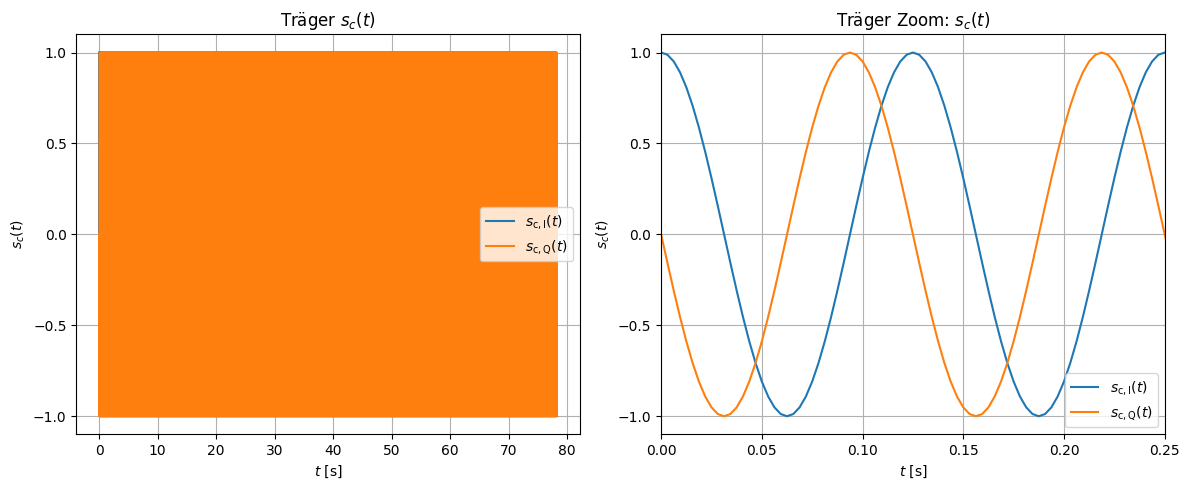

In [20]:
plot_carrier_signals(t, s_c_I, s_c_Q, f_c)

### Hoschmischen des Basisbandsignals $x_{\text{I, shaped}}(t)$ & $x_{\text{Q, shaped}}(t)$auf die Trägerfrequenz $f_c$

Wie bereits erwähnt, kann das Passbandsignal $s_{\text{HF}}(t)$ kann also wie folgt beschrieben werden:
$$
\begin{align*}
    s_{\text{HF}}(t) &= I(t) s_{\text{c,I}}(t) + Q(t) s_{\text{c,Q}}(t) \\
    &= I(t) \cos(2 \pi f_{\text{c}} t) - Q(t) \sin(2 \pi f_{\text{c}} t) \\
\end{align*}
$$
Wobei:
- $I(t) = x_{\text{I, shaped}}(t) =$ `x_i_oversampled`
- $Q(t) = x_{\text{Q, shaped}}(t) =$ `x_q_oversampled`

#### Aufgabe 11:
- Berechnen Sie $s_{\text{HF}}(t)$ in `s_hf`
- Erstellen Sie den passenden Zeitvektor `t`

In [21]:
s_hf = x_i_oversampled * s_c_I + x_q_oversampled * s_c_Q
t = np.arange(s_hf.size) * params.baseband.T_sample/oversampling_factor

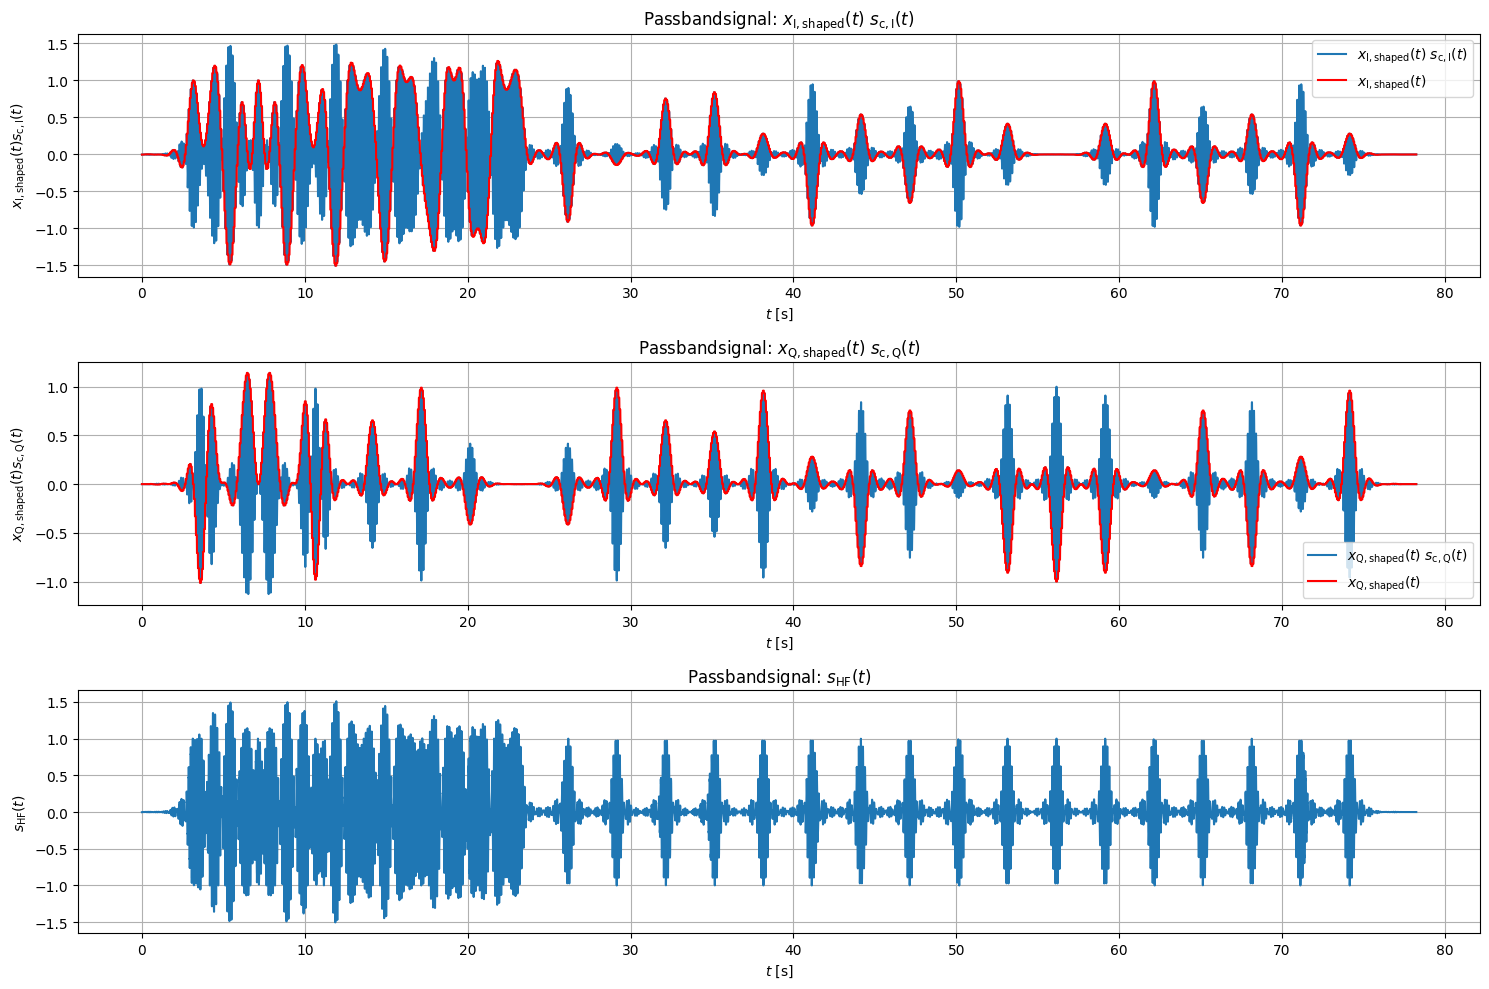

In [22]:
plot_passband_signals(t, x_i_oversampled, s_c_I, x_q_oversampled, s_c_Q, s_hf)

#### Spektrum des Passbandsignals $\mathfrak{F} \{ s_{\tiny{\text{HF}}}(t) \}$

#### Aufgabe 12:
- Berechnen Sie $\mathfrak{F} \{ s_{\tiny{\text{HF}}}(t) \}$ in `s_hf_spectrum`
- Erstellen Sie in passender Auflösung den zugehörigen Frequenzvektor `f`. Vergessen Sie nicht für die Frequenzauflösung den `oversampling_factor` zusätzlich zur vorigen Sampledauer `params.baseband.T_sample` zu berücksichtigen.

In [23]:
s_hf_spectrum = np.fft.fftshift(np.fft.fft(s_hf))
f = np.fft.fftshift(np.fft.fftfreq(s_hf.size, params.baseband.T_sample/oversampling_factor))

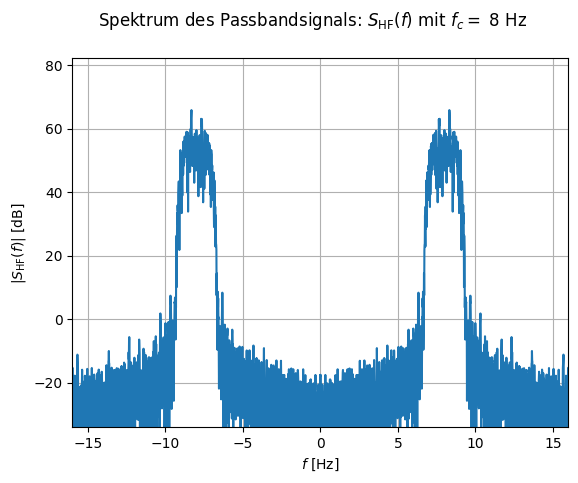

In [24]:
plot_passband_spectrum(f, s_hf_spectrum, f_c)

## Mobilfunkkanal

Bevor das Signal `s_hf` beim Empfänger ankommt, wird es durch den Mobilfunkkanal beeinflusst. Es wird ein AWGN Kanal und Freiraumausbreitung angenommen.

In [25]:
def add_awgn_noise(signal, snr_dB):
    """
    Adds AWGN noise to the signal based on the specified SNR in dB.
    :param signal: Input signal
    :param snr_dB: Signal-to-Noise Ratio in dB
    :return: Signal with added AWGN noise
    """
    signal_power = np.mean(np.abs(signal) ** 2)
    snr_linear = 10 ** (snr_dB / 10)
    noise_power = signal_power / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(len(signal)) + 1j * np.random.randn(len(signal)))
    return signal + noise

def add_channel(t: Union[Sequence[float], np.ndarray],
                signal: Union[Sequence[float], np.ndarray],
                paths_m: Union[Sequence[float], np.ndarray]) -> np.ndarray:
    dirac_sum = np.zeros_like(signal)
    c0 = scipy.constants.speed_of_light
    for d_m in paths_m:
        amplitude = np.sqrt(c0/(4*np.pi*d_m*f_c))
        dirac_sum += amplitude * Signals.delta_distribution(t, tau)
    return np.fft.ifft(np.fft.fft(s_hf)*np.fft.fft(dirac_sum)).real

In [26]:
tau = 0.125/2 + 1/f_c
c0 = 3e8
paths = np.array([tau*c0,]) #d = tau * c0
t = np.arange(s_hf.size) * params.baseband.T_sample
s_hf = add_channel(t=t, signal=s_hf, paths_m=paths)
s_hf = add_awgn_noise(signal=s_hf, snr_dB=100)

## Empfänger (Direct Downconversion)

Bei der _Direct Downconversion_, wird vom Empfangssignal im SDR der I und Q Teil separat extrahiert. So kann das reale Empfangssignal wieder in die komplexe Basisbandsignalform zurückgeführt werden.

<div style="text-align: center;">
    <img src="./images/IQ_sampling_receiver.png" alt="IQ Sampling Receiver" width="400"/>
</div>

- Gemäß Blockschaltbild wird ein Trägersignal $s_{\text{c}}(t)$ benötigt. Dieses muss die gleiche Trägerfrequenz $f_c$ haben wie auch der Träger beim Sender
    - Für den I-Anteil wird wie beim Sender $s_{\text{c,I}}(t) = \cos(2 \pi f_c t)$ verwendet (oberer Teil im Blockschaltbild)
    - Für den Q-Anteil wird eine Phasendrehung von $\Phi = \frac{\pi}{2}$ auf $ s_{\text{c,I}}(t) $ angewendet: $s_{\text{c,Q}}(t) = \cos(2 \pi f_c t + \frac{\pi}{2}) = \sin(2 \pi f_c t)$
- Wichtig: Die Schritte Heruntermischen und Filtern finden bis zur ADC kontinuierlich statt
- Bei der ADC wird das Signal mit der Sampling Rate $f_s$ *diskretisiert* und die reellen Samples *quantisiert*




## Extraktion des I-Anteils (oberer Teil im Blockschaltbild):

Das Heruntermischen von $ s_{\text{HF}}(t) $ mit dem Träger für den I-Anteil $s_{\text{c,I}}(t)$ lässt sich wie folgt beschreiben:

\begin{align*}
    \hat{I}_{\text{No Filter}}(t) &= s_{\text{HF}}(t) s_{\text{c,I}}(t) \\
    &= s_{\text{HF}}(t) \cos(2\pi f_{\text{c}} t) \\
    &= \frac{1}{2} I(t) \cos(4\pi f_{\text{c}} t) - \frac{1}{2} Q(t) \sin(4\pi f_{\text{c}} t) + \frac{1}{2} I(t)
\end{align*}
Ziel: Hochfrequente Anteile entfernen, sodass $\frac{1}{2} I(t)$ übrig bleibt.

Die hochfrequenten Anteile bei $2f_{\text{c}}$ und $-2f_{\text{c}}$ werden durch einen Tiefpassfilter $h_{\tiny{\text{TP}}}(t)$ eliminiert:

\begin{align*}
    \hat{I}_{\text{Filtered}}(t) &= \hat{I}_{\text{No Filter}}(t) * h_{\tiny{\text{TP}}}(t) \\
    &= \mathfrak{F^{-1}} \{ \hat{I}_{\text{No Filter}}(f) \cdot H_{\tiny{\text{TP}}}(f) \} \\
    &\approx x_{\text{I, shaped}}(t) \approx x_{\text{I, no shape}}(t) * h_{\tiny{\text{Pulse Form}}}(t)
\end{align*}

Der I-Anteil des Basisbandsignals $\hat{I}[n]$ wird dann durch eine ADC (Diskretisierung & Quantisierung) des Signals gewonnen:
\begin{align*}
    \hat{I}_{\text{Filtered}}(t) &\approx x_{\text{I, no shape}}(t) * h_{\tiny{\text{Pulse Form}}}(t) \\
    \hat{I}[n] &= x_{\text{I, no shape}}[n] * h_{\tiny{\text{Pulse Form}}}[n] \text{, } \quad t= \frac{n}{f_s}
\end{align*}

## Extraktion des Q-Anteils (unterer Teil im Blockschaltbild):
\begin{align*}
    \hat{Q}_{\text{No Filter}}(t) &= s_{\text{HF}}(t) s_{\text{c,Q}}(t) \\
    &= - s_{\text{HF}}(t) \sin(2\pi f_{\text{c}} t) \\
    &= - \frac{1}{2} I(t) \sin(4\pi f_{\text{c}} t) - \frac{1}{2} Q(t) \cos(4\pi f_{\text{c}} t) + \frac{1}{2} Q(t)
\end{align*}

Ziel: Hochfrequente Anteile entfernen, sodass $\frac{1}{2} Q(t)$ übrig bleibt.

Die hochfrequenten Anteile bei $2f_{\text{c}}$ und $-2f_{\text{c}}$ werden durch einen Tiefpassfilter $h_{\tiny{\text{TP}}}(t)$ eliminiert:

\begin{align*}
    \hat{Q}_{\text{Filtered}}(t) &= \hat{Q}_{\text{No Filter}}(t) * h_{\tiny{\text{TP}}}(t) \\
    &= \mathfrak{F^{-1}} \{ \hat{Q}_{\text{No Filter}}(f) \cdot H_{\tiny{\text{TP}}}(f) \} \\
    &\approx x_{\text{Q, shaped}}(t) \approx x_{\text{Q, no shape}}(t) * h_{\tiny{\text{Pulse Form}}}(t)
\end{align*}

Der Q-Anteil des Basisbandsignals $\hat{Q}[n]$ wird dann durch eine ADC (Diskretisierung & Quantisierung) des Signals gewonnen:
\begin{align*}
    \hat{Q}_{\text{Filtered}}(t) &\approx x_{\text{Q, no shape}}(t) * h_{\tiny{\text{Pulse Form}}}(t) \\
    \hat{Q}[n] &= x_{\text{Q, no shape}}[n] * h_{\tiny{\text{Pulse Form}}}[n] \text{, } \quad t= \frac{n}{f_s}
\end{align*}

## Ende: Bildung des NumPy Arrays, welches die SDR _uhd_ Bibliothek bereitstellt

Am Ende werden vom SDR die I und Q Komponenten wieder zu einem komplexen Signal zusammengefügt, dass im NumPy Array dann der Realteil eines Samples dessen I Sample enthält und der Imaginärteil dessen zugehörigen Q Sample enthält.

Ein Sample am Index $n$ eines NumPy Arrays $\text{Array}[n]$ enthält also die I- und Q-Komponente des $n$-ten Symbols:

$$
    \text{Array}[n] = I[n] + j \text{ } Q[n]
$$



## Diese Schritte werden nachfolgend einmal durchgeführt.





## 1. Heruntermischen des Signals in zurück in das Basisband

- Der obere Teil des Empfänger Blockschaltbildes führt zum Erhalt des I-Anteils.
- Der untere Teil des Empfänger Blockschaltbildes führt zum Erhalt des I-Anteils.


#### Aufgabe 13: Zeit
- Berechnen Sie $\hat{I}_{\tiny{\text{No Filter}}}(t)$ in `hat_i_no_filter`, um das heruntergemischte Signal zu erhalten
$$
     \hat{I}_{\tiny{\text{No Filter}}}(t) = s_{\tiny{\text{HF}}}(t)  s_{\text{c,I}}(t) \text{,} \quad \text{ mit } s_{\text{c,I}}(t) = \cos(2 \pi f_c t)
$$
- Berechnen Sie $\hat{I}_{\tiny{\text{No Filter}}}(t)$ in `hat_q_no_filter`, um das heruntergemischte Signal zu erhalten
$$
     \hat{I}_{\tiny{\text{No Filter}}}(t) = s_{\tiny{\text{HF}}}(t)  s_{\text{c,I}}(t) \text{,} \quad \text{ mit } s_{\text{c,I}}(t) = \cos(2 \pi f_c t)
$$
- Erstellen Sie in passender Auflösung den zugehörigen Zeitvektor `t`
#### Aufgabe 13: Frequenz
- Berechnen Sie $\hat{I}_{\tiny{\text{No Filter}}}(f) $ in `hat_i_no_filter_spectrum`, um das Spektrum des Signals zu erhalten
$$
     \hat{I}_{\tiny{\text{No Filter}}}(f)  = \mathfrak{F} \{ \hat{I}_{\tiny{\text{No Filter}}}(t)  \}
$$
- Berechnen Sie $\hat{Q}_{\tiny{\text{No Filter}}}(f) $ in `hat_q_no_filter_spectrum`, um das Spektrum des Signals zu erhalten
$$
     \hat{Q}_{\tiny{\text{No Filter}}}(f)  = \mathfrak{F} \{ \hat{Q}_{\tiny{\text{No Filter}}}(t)  \}
$$
- Erstellen Sie in passender Auflösung den zugehörigen Frequenzvektor `f`

In [27]:
hat_i_no_filter = s_hf * s_c_I # s_hf * s_c_I
hat_q_no_filter =  s_hf * s_c_Q #s_hf * s_c_Q #

t = np.arange(hat_i_no_filter.size) * params.baseband.T_sample/oversampling_factor


hat_i_no_filter_spectrum = np.fft.fftshift(np.fft.fft(hat_i_no_filter))
hat_q_no_filter_spectrum = np.fft.fftshift(np.fft.fft(hat_q_no_filter))

f = np.fft.fftshift(np.fft.fftfreq(hat_i_no_filter.size, params.baseband.T_sample/oversampling_factor))

/opt/homebrew/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


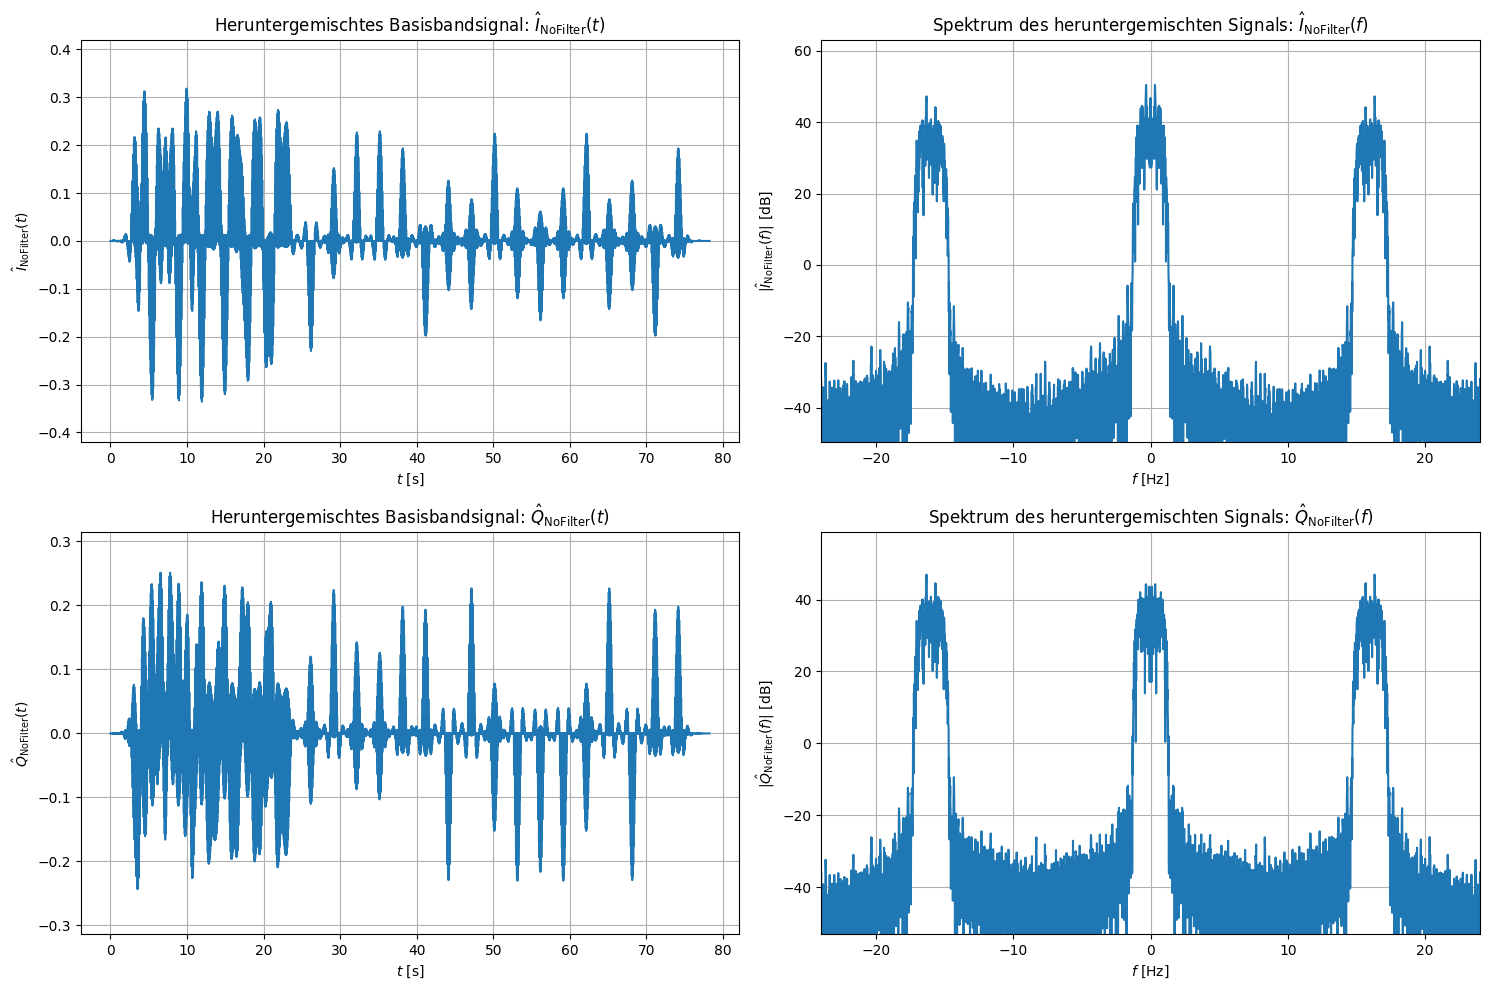

In [28]:
plot_downmixed_signals(t, hat_i_no_filter, hat_i_no_filter_spectrum,
                        hat_q_no_filter, hat_q_no_filter_spectrum, f, f_c)

### 2. Tiefpassfilterung zur Berechnung von $\hat{I}_{\text{Filtered}}(t)$

**Gegeben:**
- Frequenzarray `f` (enthält Frequenzwerte in Hz)
- Grafische Darstellung des Spektrums mit Frequenzachse in Hz

**Problemstellung:**
1. **Entfernung hochfrequenter Anteile** bei $-2f_c$ und $2f_c$
2. Bestimmung der **Abschneidefrequenz** $f_k$ (kritische Frequenz in Hz):
   - Direkt ablesbar aus der Spektrumsdarstellung
   - Alternativ rechnerisch bestimmbar
3. **Umsetzung in Python**:
   - Nullsetzen aller Array-Werte außerhalb des gewünschten Spektrums
   - Erfordert präzise Zuordnung von Frequenzwerten (Hz) zu Array-Indizes

#### Aufgabe 14: Frequenz-zu-Index-Mapping
Implementierung einer Funktion `convert_f_Hz_to_index`, die:
- Eingabe: Einzelwert `f_Hz` (Ziel-Frequenz in Hz)
- Eingabe: Frequenzarray `f` (NumPy-Array)
- Ausgabe: Index $k$ desjenigen Array-Elements, das **am nächsten** an `f_Hz` liegt


In [29]:
def convert_f_Hz_to_index(f_Hz: float, f: np.ndarray) -> int:
    """
    Findet den Index der Frequenz in einem Array `f`, die am nächsten zum Zielwert `f_Hz` liegt.

    Diese Funktion berechnet den elementweisen absoluten Unterschied zwischen dem Frequenzarray `f`
    und der Ziel-Frequenz `f_Hz` und gibt den Index des minimalen Unterschieds zurück.

    Parameter:
        f_Hz (float): Ziel-Frequenz in Hertz, für die der nächstgelegene Index gesucht wird.
        f (np.ndarray): 1D-Array von Frequenzwerten in Hertz, typischerweise aus einer FFT- oder
                        Frequenzanalyse generiert.

    Rückgabe:
        int: Index des Werts in `f`, der `f_Hz` am nächsten liegt. Bei mehreren gleichen Minima wird
             der erste auftretende Index zurückgegeben.

    Beispiele:
        >>> f = np.array([0, 100, 200, 300, 400])  # Frequenzarray in Hz
        >>> convert_f_Hz_to_index(250, f)
        2 # da 200 näher an 250 liegt als 300
        >>> convert_f_Hz_to_index(300, f)
        3 # exakte Übereinstimmung

    Anwendungskontext:
        - Nützlich zur Identifikation von Frequenzbändern in Fourier-Transformationen (FFT)
        - Mapping von physikalischen Frequenzen auf diskrete Frequenz-Indizes in Spektralanalysen
    """
    return np.argmin(np.abs(f - f_Hz))


### Design eines Filters

Ziel: Das Spektrum des heruntergemischten Signals $\mathfrak{F}\{\hat{I}_{\text{NoFilter}}(t)\}$ & $\mathfrak{F}\{\hat{Q}_{\text{NoFilter}}(t)\}$  soll durch Entfernen der Störungen bei $\pm 2f_c$ so bereinigt werden, dass im Idealfall die Hauptkomponenten des ursprüngliche Sendesignal-Spektrum $\mathfrak{F}\{x_{\text{I, shaped}}(t)\}$ & $\mathfrak{F}\{x_{\text{Q, shaped}}(t)\}$ (vor der Hochmischung) übrig bleiben.

$$
    \hat{I}_{\text{NoFilter}}(t) = \frac{1}{2} I(t) \cos(4\pi f_{\text{c}} t) - \frac{1}{2} Q(t) \sin(4\pi f_{\text{c}} t) + \frac{1}{2} I(t)
$$
$$
    \hat{Q}_{\text{NoFilter}}(t) = - \frac{1}{2} I(t) \sin(4\pi f_{\text{c}} t) - \frac{1}{2} Q(t) \cos(4\pi f_{\text{c}} t) + \frac{1}{2} Q(t)
$$

#### Aufgabe 15:
- Designen Sie ein solches Filter $H_{\tiny{\text{TP}}}(f)$ in `H_tp`, welches das Ziel erreichen kann (Hinweis: Ein Rechteck Signal $\text{rect}(f)$ könnte ein solches Verhalten erzielen)
- Erstellen Sie in passender Auflösung den zugehörigen Frequenzvektor `f`
- Verwenden Sie dabei die oben implementierte Funktion `convert_f_Hz_to_index`, welche `f_Hz` auf dessen Frequenzindex $k$ abbildet.
- Vergessen Sie nicht mit dem Filter gleichzeitig den Faktor $\frac{1}{2}$ im letzten Summanden aus $\hat{I}_{\text{NoFilter}}(t)$ `I_hat_i_no_filter` zu korrigieren.

In [30]:
f = np.fft.fftshift(np.fft.fftfreq(len(hat_i_no_filter), params.baseband.T_sample/oversampling_factor))

H_tp = np.zeros(f.size)
# correct the 1/2 factor from downconversion

border = 1/params.baseband.T_s # b = 1 / T_s
# index from f at border
left_index = convert_f_Hz_to_index(-border, f)
rigth_index = convert_f_Hz_to_index(border, f) + 1
H_tp[left_index:rigth_index] = 1
H_tp = H_tp * 2

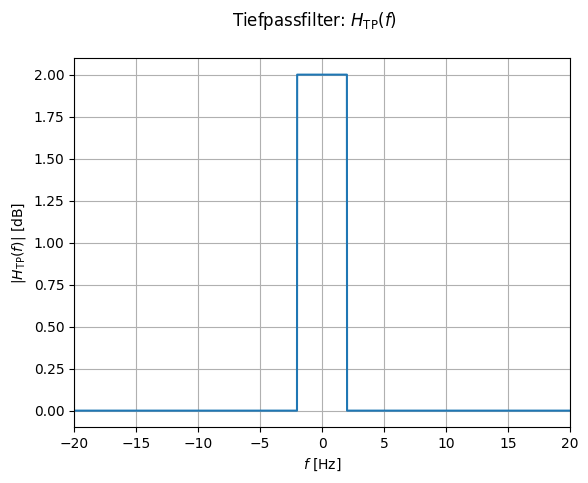

In [31]:
plot_lowpass_filter(f, H_tp, border)

#### Aufgabe 16:
- Wenden Sie $H_{\tiny{\text{TP}}}(f)$ auf $\hat{I}_{\text{NoFilter}}(f)$ und legen Sie das Ergebnis in `hat_i_filtered_spectrum` ab:
$$
    \hat{I}_{\text{Filtered}}(f) = \hat{I}_{\text{NoFilter}}(f) \cdot H_{\tiny{\text{TP}}}(f)
$$
- Wenden Sie $H_{\tiny{\text{TP}}}(f)$ auf $\hat{Q}_{\text{NoFilter}}(f)$ und legen Sie das Ergebnis in `hat_q_filtered_spectrum` ab:
$$
    \hat{Q}_{\text{Filtered}}(f) = \hat{Q}_{\text{NoFilter}}(f) \cdot H_{\tiny{\text{TP}}}(f)
$$
- Erstellen Sie in passender Auflösung den zugehörigen Frequenzvektor `f`


In [32]:
hat_i_filtered_spectrum = hat_i_no_filter_spectrum * H_tp
hat_q_filtered_spectrum = hat_q_no_filter_spectrum * H_tp
f = np.fft.fftshift(np.fft.fftfreq(hat_i_filtered_spectrum.size, params.baseband.T_sample/oversampling_factor))

/Users/sonnywandel/PycharmProjects/sdr-module/utilities/plots/iq_sampling_plots.py:438: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(f, 10 * np.log10(np.abs(hat_i_filtered_spectrum) ** 2))
/Users/sonnywandel/PycharmProjects/sdr-module/utilities/plots/iq_sampling_plots.py:443: RuntimeWarning: divide by zero encountered in log10
  max_val_i = np.max(10 * np.log10(np.abs(hat_i_filtered_spectrum) ** 2))
/Users/sonnywandel/PycharmProjects/sdr-module/utilities/plots/iq_sampling_plots.py:447: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(f, 10 * np.log10(np.abs(hat_q_filtered_spectrum) ** 2))
/Users/sonnywandel/PycharmProjects/sdr-module/utilities/plots/iq_sampling_plots.py:452: RuntimeWarning: divide by zero encountered in log10
  max_val_q = np.max(10 * np.log10(np.abs(hat_q_filtered_spectrum) ** 2))


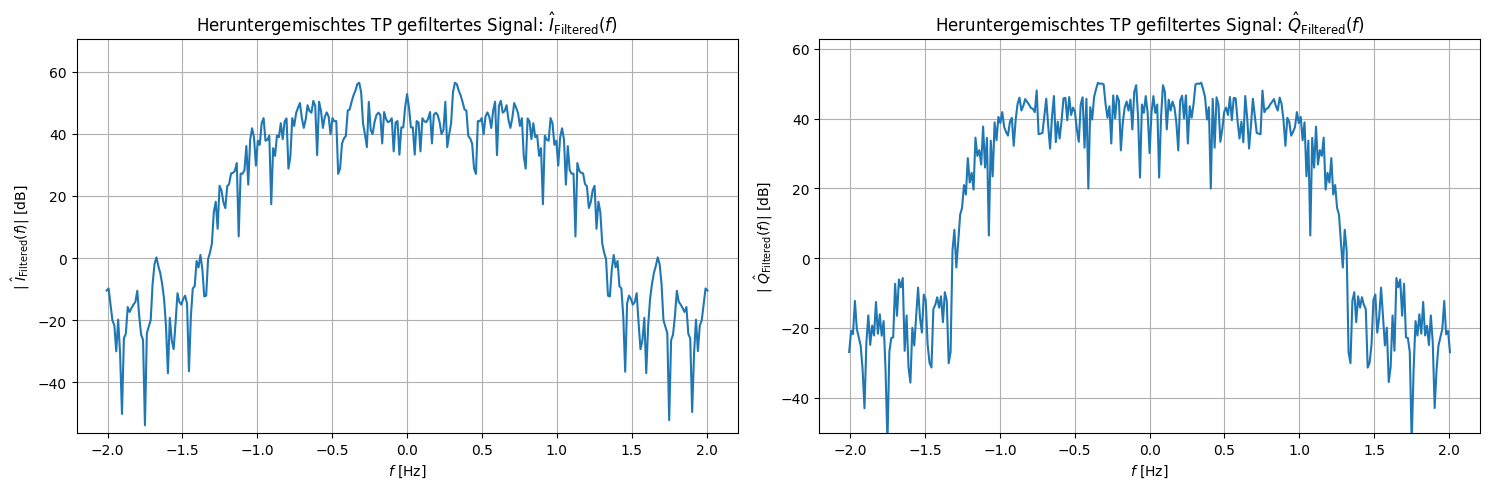

In [33]:
plot_filtered_spectra(f, hat_i_filtered_spectrum, hat_q_filtered_spectrum)

#### Aufgabe 17:
- Transformieren Sie nun $\hat{I}_{\text{Filtered}}(f)$ wieder in den Zeitbereich und wenden darauf die Umkehrung des Oversamplings `invert_oversampling` und speichern das Ergebnis in `hat_i_filtered`
- Transformieren Sie nun $\hat{Q}_{\text{Filtered}}(f)$ wieder in den Zeitbereich und wenden darauf die Umkehrung des Oversamplings `invert_oversampling` und speichern das Ergebnis in `hat_q_filtered`
- Erstellen Sie dazu einen passenden Zeitvektor `t`

In [34]:
hat_i_filtered = invert_oversampling(np.fft.ifft(np.fft.fftshift(hat_i_filtered_spectrum)).real, oversampling_factor)
hat_q_filtered = invert_oversampling(np.fft.ifft(np.fft.fftshift(hat_q_filtered_spectrum)).real, oversampling_factor)

t = np.arange(hat_q_filtered.size) * params.baseband.T_sample

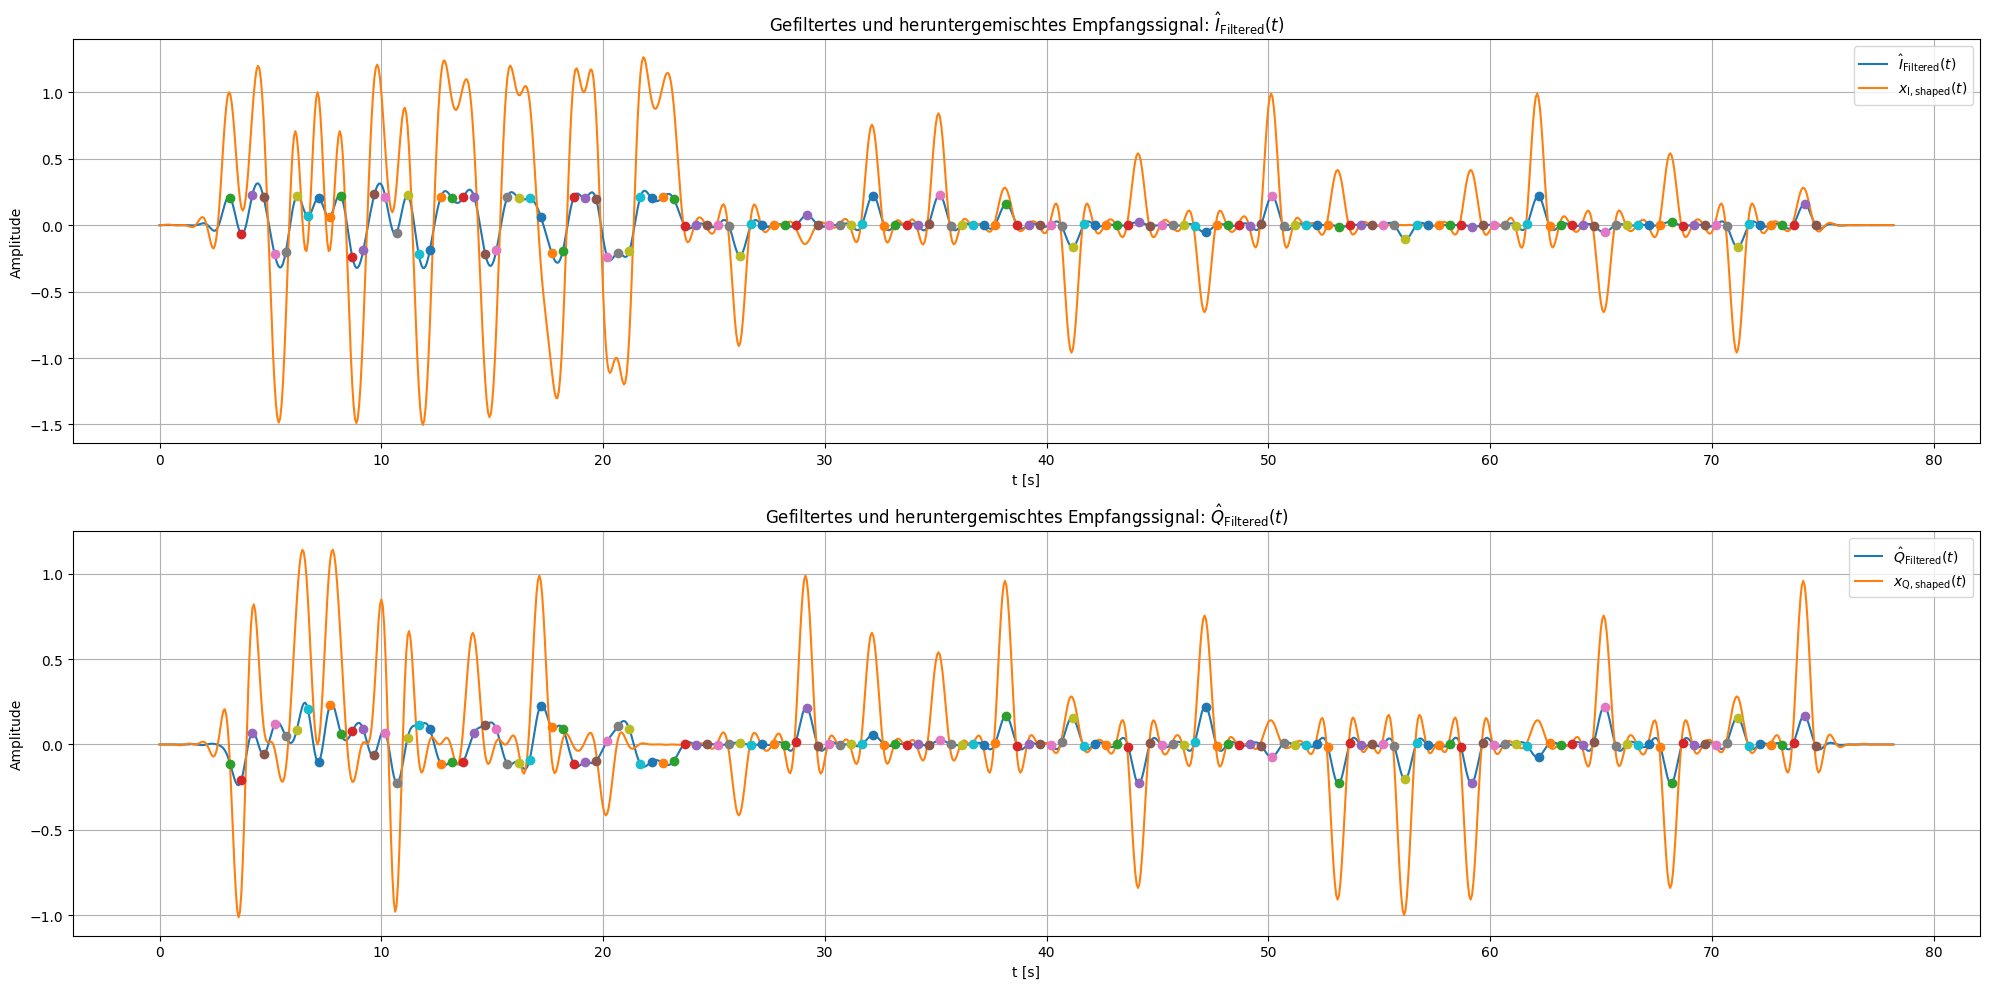

In [35]:
plot_filtered_signals(t, hat_i_filtered, x_i_shaped, hat_q_filtered, x_q_shaped, params, symbols)

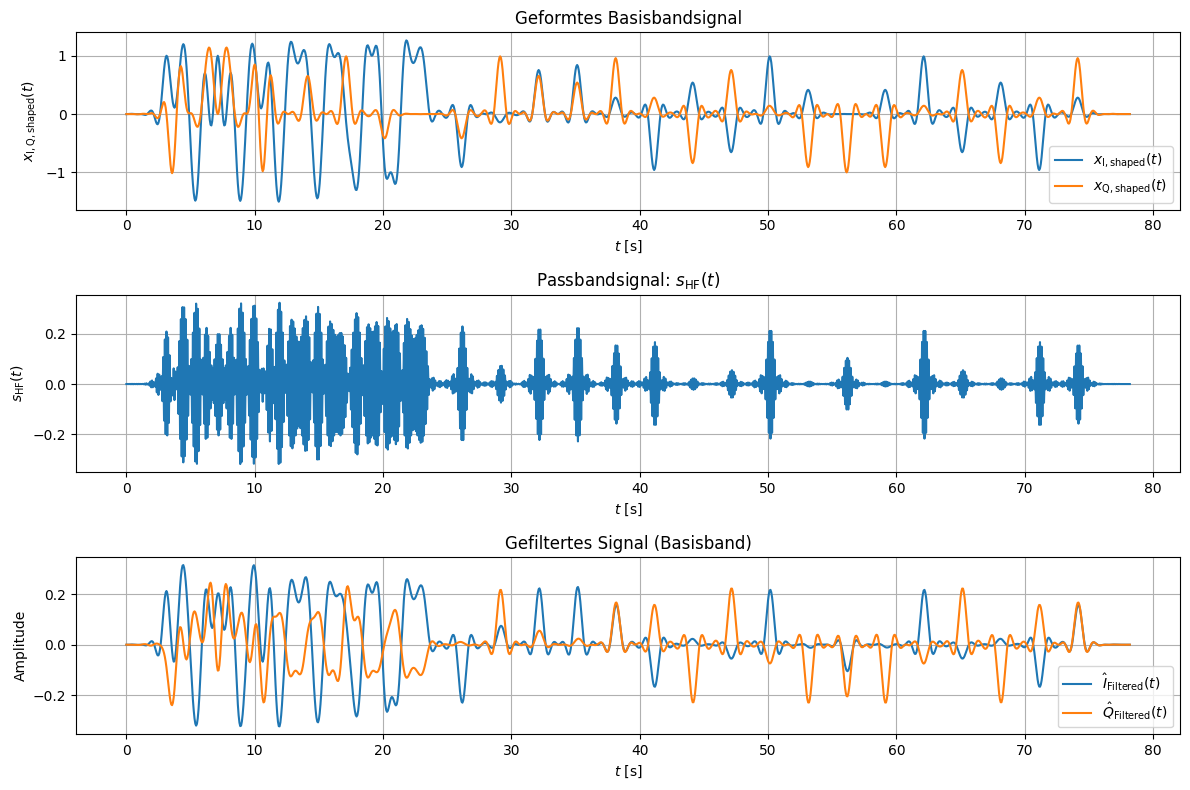

In [36]:
plot_signals(t, x_i_shaped, x_q_shaped, s_hf[::oversampling_factor], hat_i_filtered, hat_q_filtered)

# Frage: Woher kommen wenn ein Rechteck als Basisbandpulsform verwendet wird unten nach der Tiefpassfilterung die Überschwinger?
- Ein Rechteck hat eine unendliche Bandbreite
- Bei der Tiefpassfilterung werden die hohen Frequenzen abgeschnitten
- Die Überschwinger kommen also daher, dass die hohen Frequenzen abgeschnitten werden und somit im Zeitbereich Überschwinger entstehen

/Users/sonnywandel/PycharmProjects/sdr-module/utilities/plots/iq_sampling_plots.py:584: RuntimeWarning: divide by zero encountered in log10
  plt.plot(f, np.fft.fftshift(10 * np.log10(np.abs(np.fft.fft(hat_i_filtered_normalized)) ** 2)), color='black',
/Users/sonnywandel/PycharmProjects/sdr-module/utilities/plots/iq_sampling_plots.py:592: RuntimeWarning: divide by zero encountered in log10
  max_value = np.max(10 * np.log10(np.abs(np.fft.fft(hat_i_filtered_normalized)) ** 2))


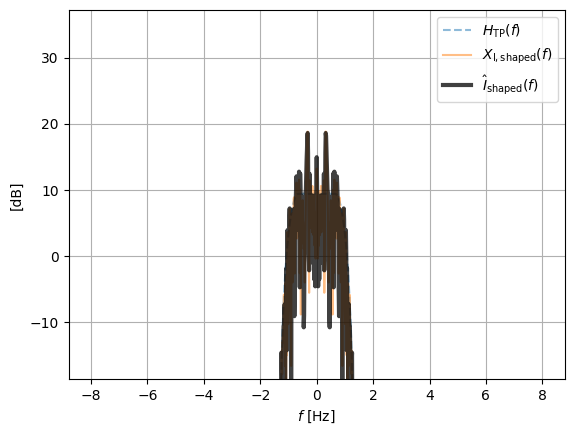

In [37]:
f = np.fft.fftshift(np.fft.fftfreq(hat_i_filtered.size, params.baseband.T_sample))

base_band_pulse = RectPulse(T_s=params.baseband.T_s, num_samples=hat_i_filtered.size, sps=params.baseband.sps) if params.baseband.pulseform is BasebandPulseForm.RECT else RaisedCosinePulse(T_s=params.baseband.T_s, num_samples=hat_i_filtered.size, sps=params.baseband.sps, roll_off=params.baseband.roll_off)

hat_i_filtered_normalized   = normalize_energy(hat_i_filtered)
x_i_shaped_normalized       = normalize_energy(x_i_shaped)
baseband_signal_normalized  = normalize_energy(base_band_pulse.generate_pulse())

plot_spectra(f, baseband_signal_normalized, x_i_shaped_normalized, hat_i_filtered_normalized)

## 3. ADC von $\hat{I}_{\tiny{\text{Filtered}}}(t)$ & $\hat{Q}_{\tiny{\text{Filtered}}}(t)$

#### Aufgabe 18:
- Führen sie das Sampling für $\hat{I}_{\tiny{\text{Filtered}}}(t)$, welches in `I_hat_i_filtered` gespeichert ist aus (Hinweis: $f_s =$ `params.baseband.sps`)
- Aufgrund des Filterns wurde $\hat{I}_{\tiny{\text{Filtered}}}(t)$ komplex
- Speichern Sie den Realteil der Samples in `real_part`
- $\hat{Q}_{\tiny{\text{Filtered}}}(t) = 0$, da BPSK verwendet wurde. Der Vollständigkeit halber wird es hier dennoch berücksichtigt.
- Führen Sie `real_part` und `imag_part` in ein NumPy Array `sdr_iq_samples` vom Typ `np.complex64` zusammen, wobei: `sdr_iq_samples`$[i] =$ `real_part`$[i]$ + $j$ ` imag_part`$[i]$
- Dies ist das Ergebnis, welches Ihnen die uhd Bibliothek nach einer Messung bereitstellt

In [38]:
fs = params.baseband.sps

# Das ist nun der I Teil des empfangenen Signals
real_part = hat_i_filtered[::fs].real
imag_part = hat_q_filtered[::fs].real

# Das SDR liefert nun daraus ein NumpPy Array mit dem dtype complex64
sdr_iq_samples = (real_part + 1j * imag_part).astype(np.complex64)
sdr_iq_samples

array([-1.78605333e-04+9.84544968e-05j,  7.71748426e-04-1.99866685e-04j,
       -5.27346041e-04-8.92294629e-04j, -2.51352089e-03+1.98723795e-03j,
        1.39564537e-02-2.73901457e-03j, -4.20994200e-02+2.79213674e-03j,
        1.86191723e-01-4.81540188e-02j,  1.42695494e-02-2.35904008e-01j,
        7.61066824e-02+1.29416439e-04j,  3.04546535e-01-1.85125396e-02j,
       -6.07588403e-02+4.63724993e-02j, -3.12739819e-01+1.03237592e-01j,
        1.18242063e-01+1.61393620e-02j,  1.18408464e-01+2.40689874e-01j,
        1.68461502e-01-4.85046282e-02j,  8.64034668e-02+1.17068976e-01j,
        2.02355891e-01+1.53881192e-01j, -4.67707627e-02+3.38146351e-02j,
       -3.03903997e-01+1.26637653e-01j,  8.78193676e-02-4.95696701e-02j,
        3.06190938e-01+6.37931526e-02j, -3.70172001e-02-1.44731104e-01j,
        1.59160897e-01-8.75789151e-02j, -1.38254333e-02+1.10632196e-01j,
       -3.07736129e-01+1.24720193e-01j,  9.38090011e-02-5.33344075e-02j,
        2.45807424e-01-1.12898782e-01j,  1.70402110

(<Figure size 1200x500 with 3 Axes>,
 array([<Axes: title={'center': 'Realteil: $ x_{\\rm{I}}[n] $'}, xlabel='$n$', ylabel='$x_{\\rm{I}}[n]$'>,
        <Axes: title={'center': 'Imaginärteil: $ x_{\\rm{Q}}[n]$'}, xlabel='$n$', ylabel='$x_{\\rm{Q}}[n]$'>,
        <Axes: title={'center': 'IQ-Plot'}, xlabel='$\\Im$', ylabel='$\\Re$'>],
       dtype=object))

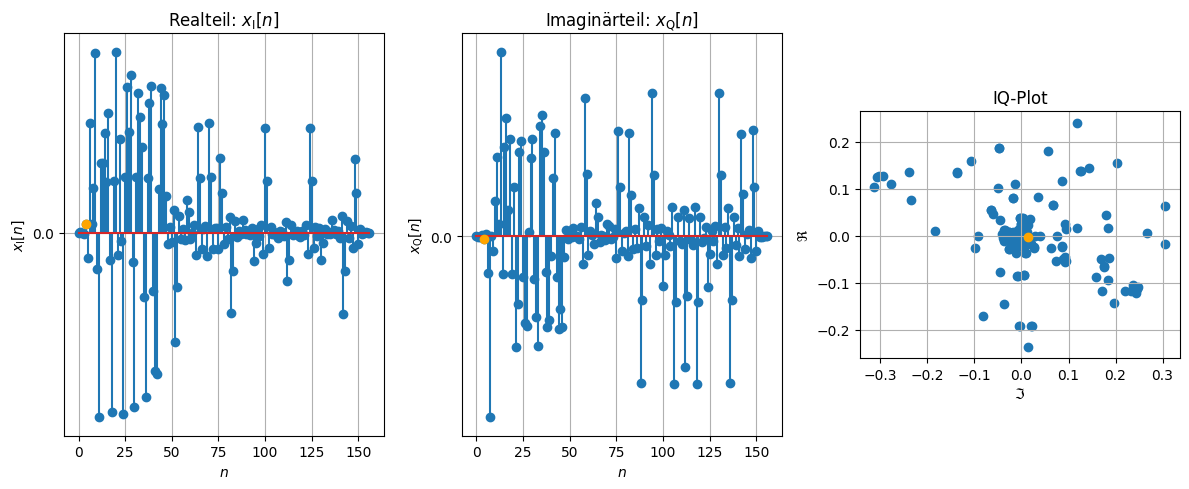

In [39]:
plot_iq_samples(x=sdr_iq_samples)

# RX: Synchronisation, Equalization & Demodulation

## Synchronisation

Zur Synchronisation soll ein Korrelationsempfänger implementiert werden. Dazu wird die Maximum Correlation verwendet.

- Gegeben seien die Empfangssamples $r[n]$. Darin findet sich die Rahmenstruktur des TX wieder, somit auch die Synchronisationssequenz $x[n]$. Allerdings wurden die Samples des Frames zeitlich verschoben. Es ist also unbekannt, an welchem Index $n$ der Frame in $r[n]$ beginnt.
- Ziel: Finden des Startzeitsamples $\tau_0$ der bekannten Synchronisationssequenz $x[n]$, welche sich in $r[n]$ befindet.
- Mathematische Operation:

$$
\tau_0 = \underset{\tau}{\text{argmax}} \left\{ \sum_{n = 0}^{N-1} r[n + \tau] \text{ } \overline{x[n]} \right\}
$$

- $N$ ist die Anzahl der Samples der Synchronisationssequenz $x[n]$

Aufgrund der Korrelationseigenschaften der verwendeteten Sychronisationssequenz, ensteht das Maximum genau dann, wenn die bekannte Sequenz $x[n]$ und die Synchronisationssequenz $\hat{x}[n]$ im Empfangssignal genau übereinander liegen.

In [40]:
iq_receiver = IQReceiver(
    params=params,
    sdr_samples=sdr_iq_samples,
    known_sync_seq=iq_sender.sync_seq,
    symbols_without_zero_padding=iq_sender.modulation_symbols.size
)

Aufgabe 19: Korrelationsempfänger
Aufgabe 20: Extraktion der Rahmendaten
Aufgabe 21: Generierung der Basis Piloten-Sequenz
Aufgabe 22: Extraktion der Pilotensequenz
Aufgabe 23: Zyklische Korrelation
Aufgabe 24: Berechnung der tatsächlich verwendeten Pilotensequenz
Aufgabe 25: Kanalschätzung und Equalization
Aufgabe 26: Auslesen der entzerrten Datensymbole
Aufgabe 27: Entfernen der Zero-Padding-Symbole


/Users/sonnywandel/PycharmProjects/sdr-module/utilities/IQReceiver/IQReceiver.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  self.corr[i] = np.dot(self.sdr_samples[i:i + len(self.known_sync_seq)],


### Aufgabe 19: Korrelationsempfänger

Diese und die nachfolgenden Aufgaben, werden wieder wie auch im obigen Teil des Notebooks außerhalb des Notebooks implementiert.

- Die obige Formel zur Synchronisation soll in der Python Funktion utilities/IQReceiver/IQReceiver.time_synchronization() implementiert werden.
- Das Mapping zwischen Formelzeichen und IQSender Variable ist gegeben durch:
    - $r[n]$ -> `self.sdr_samples`
    - $x[n]$ -> `self.known_sync_sec`
- Output: Tupel (tau0, corr)
    - tau0 ist ein Integer, dessen Wert der Index des Maximums vom Korrelationsergebnis sein soll
    - corr ist das Korrelationsergebnis




Aufgabe 19: Korrelationsempfänger


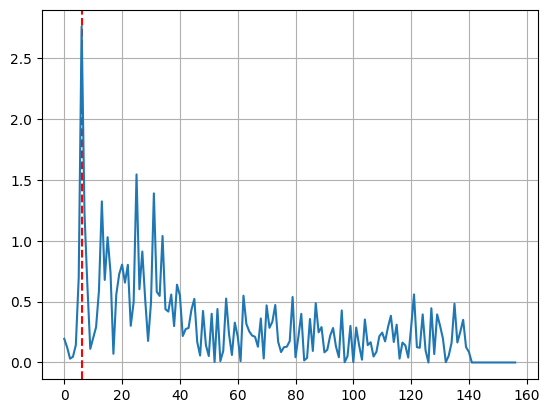

In [41]:
tau0, corr = iq_receiver.time_synchronization()
plt.axvline(iq_receiver.tau0, color='r', linestyle='--')
plt.plot(np.abs(corr))
plt.grid(True)

In [42]:
print(f"tau0: {tau0}")
print(f"rx len: {len(sdr_iq_samples)}")


tau0: 6
rx len: 157


<Figure size 1920x1440 with 0 Axes>

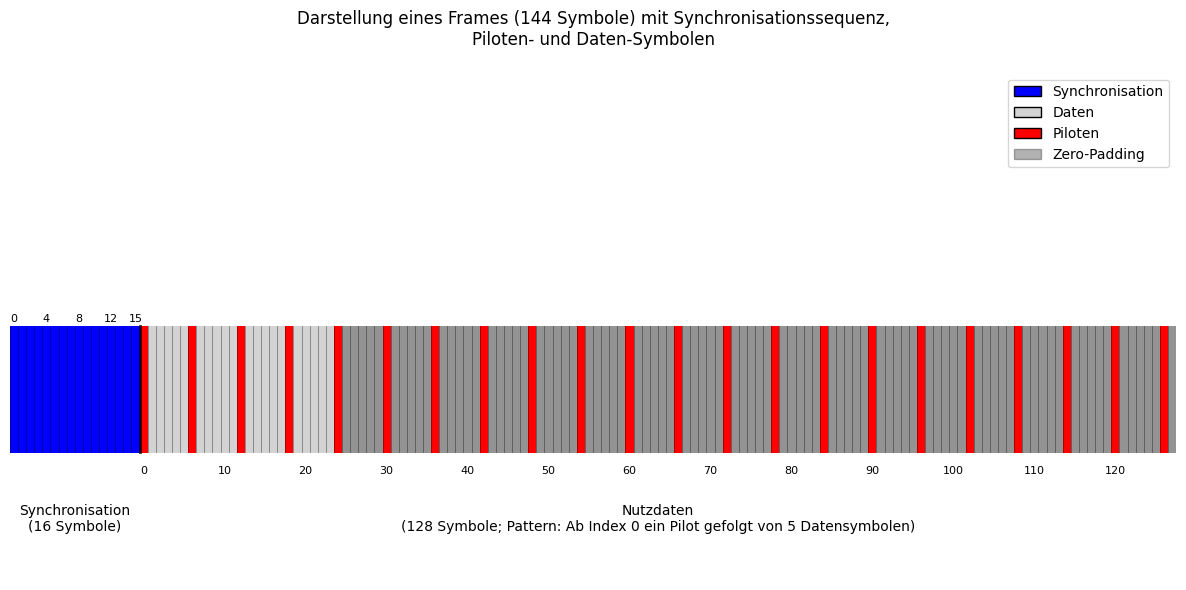

In [43]:
plot_frame(frame_params=params.frame, zero_padded_indexes=zero_padded_indexes)

## Extraktion der Nutzdatensamples aus $r[n]$ mithilfe von $\tau_0$

$r[n]$ enthält jede Menge Samples der simulierten Messung, die nicht zum Frame gehören, welcher extrahiert werden soll. Daher soll dieser Schritt alle Samples extrahieren, welche Teil des Frames sind. Alle anderen Samples sollen verworfen werden.

- Da Sie nun $\tau_0$ kennen, wissen Sie, ab welchem Index der Frame im Empfangssignal `iq_receiver.sdr_samples` liegt.
- Sie wissen, dass der blaue Teil (Synchronisationssequenz) im Frame oben `frame.num_sync_syms` Samples hat
- Sie wissen, dass der graue Teil danach (Daten & Piloten)
 `params.frame.num_data_syms` Samples lang ist.

### Aufgabe 20: Extraktion der Frame Samples
- Implementieren Sie die Funktion IQSender.extract_frame_samples(), welche alle Samples, die zum Frame gehören extrahiert.

In [44]:
data_symbols_received = iq_receiver.extract_frame_samples()
data_symbols_received.shape

Aufgabe 20: Extraktion der Rahmendaten


(128,)

## MCS Detection & Equalization

Die Information, welches MCS verwendet wurde steckt in der zyklischen Verschiebung der Zadoff-Chu Sequenz, welche als Piloten Sequenz verwendet wurde.

Ziel: Basis Sequenz bekannt --> zyklischer Verschiebungsindex muss erkannt werden. [Mapping MCS Verschiebungsindex](/utilities/enums/ModulationCodingSchemeShift.py)

#### 1. Nachbilden der bekannten Sequenz aus den Parametern der Übertragung

- Es ist im `IQSender.py` in `self.params.frame.pilot_zc_root` die Wurzel der Basis ZC-Sequenz bekannt.
- Die Länge der Pilotensequenz ergibt sich aus dem konfigurierten Pattern: `self.frame_params.num_data_syms` & `self.frame_params.pilot_repetition` (Siehe Frame Plot)

## Aufgabe 21: Generierung der Basis Piloten-Sequenz
- Implementieren Sie die Funktion IQReceiver.get_base_pilot_seq(), welche die bekannte nicht zyklisch verschobene Pilotensequenz nachbildet
- Hinweis: Verwenden Sie hierzu `SynchronizationSequences.zadoff_chu_sequence`

In [45]:
known_base_pilot_seq = iq_receiver.get_base_pilot_seq()

Aufgabe 21: Generierung der Basis Piloten-Sequenz


### 2. Extraktion der Pilotensequenz aus den Empfangssamples aus dem Datenteil

Für die einfachere Handhabung für die Erkennung des Verschiebungsindexes soll im nächsten Schritt die vom Sender gemultiplexte Pilotensequenz aus `iq_receiver.frame_samples` extrahiert werden.

#### Aufgabe 22: Extraktion der Pilotensequenz

- Implementieren Sie die Funktion demultiplex_pilots() in IQReceiver.
- Sie brauchen hierzu die Indexe der Pilotensymbole aus `self.params.frame.num_data_syms` und `self.params.frame.pilot_repetition`

In [46]:
pilot_seq = iq_receiver.demultiplex_pilots()

Aufgabe 22: Extraktion der Pilotensequenz


### 3. Zyklische Korrelation der Pilotensequenz & Extraktion des Verschiebungsindexes

#### Aufgabe 23: Zyklische Korrelation

- Berechnen Sie die zyklische Korrelation in der Funktion estimate_mcs_shift() im IQReceiver zwischen:
    - `self.base_pilot_seq` & `self.pilot_seq`
- Output: Tupel (corr, corr_max)
    - corr: Ergebnis der zyklischen Korrelation
    - corr_max: Index des Maximums der zyklischen Korrelation

In [47]:
cyclic_correlation, mcs_shift = iq_receiver.estimate_mcs_shift()



Aufgabe 23: Zyklische Korrelation


/opt/homebrew/lib/python3.11/site-packages/matplotlib/transforms.py:2860: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


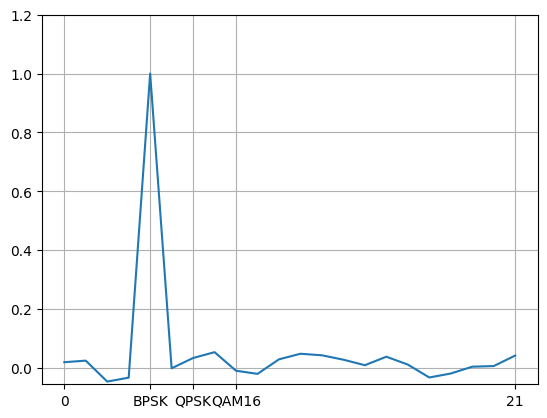

In [48]:
plt.plot(cyclic_correlation)
plt.ylim(np.min(cyclic_correlation) * 1.2, 1.2)

bpsk = ModulationCodingSchemeShift.BPSK.value
qpsk = ModulationCodingSchemeShift.QPSK.value
qam16 = ModulationCodingSchemeShift.QAM16.value
plt.xticks([0, bpsk, qpsk, qam16, cyclic_correlation.size-1], ["0", "BPSK", "QPSK", "QAM16", f"{cyclic_correlation.size-1}"])
plt.grid(True)

#### Mapping des Verschiebungsindexes `mcs_shift` auf MCS

Maximum $\hat{=}$ Verschiebungsindex (Korrelationseigenschaft)


In [49]:
if ModulationCodingSchemeShift.BPSK.value == mcs_shift:
    mcs = ModulationCodingScheme.BPSK
elif ModulationCodingSchemeShift.QPSK.value == mcs_shift:
    mcs = ModulationCodingScheme.QPSK
elif ModulationCodingSchemeShift.QAM16.value == mcs_shift:
    mcs = ModulationCodingScheme.QAM16
else:
    raise Exception("MCS could not be detected.")

print(mcs)

BPSK


# Equalization

### Berechnung der Pilotensequenz die tatsächlich verwendet wurde

Sie wissen nun welcher Verschiebungsindex `self.mcs_shift` auf die Basissequenz angewendet wurde.

Die Basissequenz im IQSender haben Sie in Aufgabe 21 bereits berechnet und kann unter `self.base_pilot_seq` abgerufen werden.

#### Aufgabe 24: Berechnung der tatsächlich verwendeten Pilotensequenz

- Wenden Sie in calculate_used_pilot_seq() im IQReceiver eine zyklische Verschiebung nach rechts auf `self.base_pilot_seq` um `self.mcs_shift` Positionen an.

In [50]:
used_pilot_seq = iq_receiver.calculate_used_pilot_seq()


Aufgabe 24: Berechnung der tatsächlich verwendeten Pilotensequenz


## Equalization: Jeder Pilot entzerrt die nachfolgenden Datensymbole bis zum nächsten Piloten, ...

In der vorigen Aufgabe haben Sie die tatstächlich vom Sender verwendete Pilotensequenz bestimmt. Diese ist im IQSender nun in `self.used_pilot_seq` verfügbar.

Da sie nun genau wissen welche Symbole ursprünglich ausgesendet wurden, können Sie die Pilotensequenz nun für die Equalization der Datensymbole verwenden.
#### Aufgabe 25: Kanalschätzung und Equalization

- Implementieren Sie die Funktion channel_equalization() in IQReceiver.
- Basierend auf einem Pilotensymbol können sie den Kanal schätzen
- Diese Schätzung können Sie dann für die Equalization der nachfolgendenden Datensymbole bis zum nächsten Piloten verwenden, ...
- Hinweis: Für das Indexing kann der obige Frame Plot hilfreich sein.

In [51]:
data_symbols_received_eq = iq_receiver.channel_equalization()

Aufgabe 25: Kanalschätzung und Equalization


#### Aufgabe 26: Auslesen der entzerrten Datensymbole

Ziel: Ein Array, welches ausschließlich aus Datensymbolen besteht (keine Piloten).

- Implementieren Sie die Funktion remove_pilot_symbols() im IQReceiver
- Aus `self.frame_samples` sollen die Datensymbole ohne Piloten ausgelesen werden
- Hinweis: Für das Indexing kann der obige Frame Plot hilfreich sein.

In [52]:
data_symbols_without_pilots = iq_receiver.remove_pilot_symbols()

Aufgabe 26: Auslesen der entzerrten Datensymbole


#### Aufgabe 27: Entfernen der Zero-Padding-Symbole

Ziel: Ein Array, welches ausschließlich aus Datensymbolen besteht (keine Piloten und auch keine Symbole, die durch Zero-Padding entstanden sind).

- Implementieren Sie die Funktion remove_zero_padded_symbols im IQReceiver
- Aus `self.frame_samples_without_pilots` sollen die Zero-Padding Symbole entfernt werden
- Die Information über die Anzahl der Datensymbole ohne Zero-Padding ist unter `self.symbols_without_zero_padding` verfügbar.
- Hinweis: Für das Indexing kann der obige Frame Plot hilfreich sein.

In [53]:
data_symbols_without_pilots_and_zero_padding = iq_receiver.remove_zero_padded_symbols()

Aufgabe 27: Entfernen der Zero-Padding-Symbole


In [54]:
data_symbols_received.size, data_symbols_received_eq.size

(128, 128)

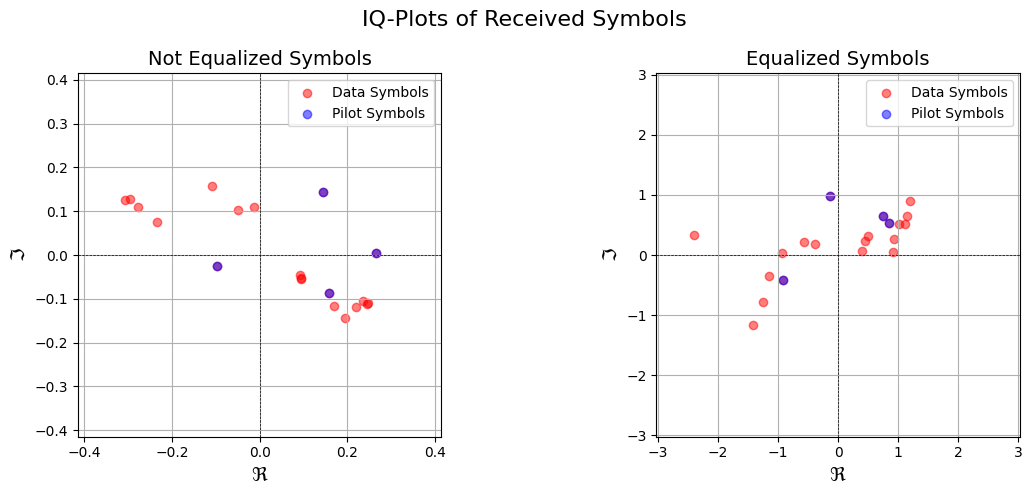

In [55]:
plot_iq_symbols(data_symbols_received[:iq_sender.modulation_symbols.size], data_symbols_received_eq[:iq_sender.modulation_symbols.size], params, params.frame.pilot_start_idx, params.frame.pilot_repetition)

#### Aufgabe 28: Demodulation

Implementieren Sie für BPSK und QPSK die Demodulation in utilities/IQReceiver/Demodulator.py.

Die Signaturen der Funktionen sind bereits definiert.

In [56]:
data_bits_received = iq_receiver.demodulate()
print(f"used Modulation Coding Scheme = {mcs}")
print("bits^hat = ", data_bits_received)
print("bits     = ", data_bits)

used Modulation Coding Scheme = BPSK
bits^hat =  [0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1]
bits     =  [0 0 1 1 1 0 0 1 1 1 0 0 1 1 1 0 0 1 1 1]
